In [29]:
import torch
from torch import nn,optim
import functools
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.utils as vutils

In [30]:
import random
import numpy as np
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
from skimage.transform import resize

In [31]:
from tensorboardX import SummaryWriter
writer=SummaryWriter('/user1/faculty/cvpr/ujjwal/dhritimaan/GANs/datasets/log_cycle_gan_normal/')

In [32]:
class SequenceFolder(data.Dataset):
    def __init__(self, trainA,trainB):
        self.trainA=trainA
        self.trainB=trainB

    def __len__(self):
        return 1556
    def __getitem__(self, index):
        index_a=index%len(self.trainA)
        index_b=index%len(self.trainB)
        imgA=plt.imread(self.trainA[index_a])
        imgB=plt.imread(self.trainB[index_b])
        imgA=resize(imgA,(256,256,3))
        imgB=resize(imgB,(256,256,3))
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
        #index=index%
        dict_img={'A':imgA,'B':imgB}
        return dict_img

In [33]:
#plt.imread(foggy_paths[0]).shape
import os

In [34]:
file1 = open("/user1/faculty/cvpr/ujjwal/kaiser/dataset/foggy_zurich/Foggy_Zurich/lists_file_names/RGB_medium_filenames.txt",
             "r")
x=file1.read()
foggy_paths=[os.path.join('/user1/faculty/cvpr/ujjwal/kaiser/dataset/foggy_zurich/Foggy_Zurich',t) for t in x.splitlines()]

In [35]:


import os
city=os.listdir('/user1/faculty/cvpr/ujjwal/kaiser/dataset/cityscape/leftImg8bit/train')

In [36]:

img_paths=[]
for i in range(10):
    city_path=os.path.join('/user1/faculty/cvpr/ujjwal/kaiser/dataset/cityscape/leftImg8bit/train',city[i])
    img_names=os.listdir(city_path)
    k=[os.path.join(city_path,s) for s in img_names]
    for j in range(len(k)):
        img_paths.append(k[j])

In [37]:
#foggy_paths

In [38]:
train=SequenceFolder(foggy_paths,img_paths)#lista,listb)

In [39]:
dataloader=torch.utils.data.DataLoader(train,batch_size=3,shuffle=True)

In [40]:
import matplotlib.pyplot as plt
for a,b in enumerate(dataloader):
    a
    break

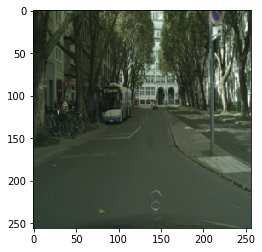

In [41]:
import matplotlib.pyplot as plt
plt.imshow(b['B'][0])

In [42]:
b['B'].permute(0,3,1,2).shape

torch.Size([3, 3, 256, 256])

In [43]:
#torch.cat((b['A'].permute(0,3,1,2),b['B'].permute(0,3,1,2)),1).shape

In [44]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [45]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [46]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [47]:
#os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(str(x) for x in [0,1,2])
cuda=torch.device('cuda:1')
#device_ids=opt.gpus
genAB=ResnetGenerator(3,3).to(cuda)
genBA=ResnetGenerator(3,3).to(cuda)

In [48]:
discAB=NLayerDiscriminator(3).to(cuda)
discBA=NLayerDiscriminator(3).to(cuda)

In [49]:
from itertools import chain

In [50]:
gen_optim=optim.Adam(chain(genAB.parameters(),genBA.parameters()),lr=0.0002,betas=(0.5,0.999))
dis_optim=optim.Adam(chain(discAB.parameters(),discBA.parameters()),lr=0.0002,betas=(0.5,0.999))

In [51]:
#loss_ce=nn.NLLLoss()
loss_mse=nn.MSELoss()
#loss_rec=l1loss()

In [52]:
def l1loss(x,y):
    return torch.mean(torch.abs(x-y))
def mse(x,y):
    return torch.mean((x-y)**2)

In [53]:
#nn.L1Loss()
import skimage

In [54]:
from skimage.transform import resize

In [55]:
#genAB(torch.cat((b['A'],b['A']),1).permute(0,3,1,2).float().to(cuda)/255)
import pytorch_ssim
ssim_loss=pytorch_ssim.SSIM()

In [ ]:
num_epochs=100
count=0
for epoch in range(num_epochs):
    for n_batches,real_data in enumerate(dataloader):
        realA=real_data['A'].permute(0,3,1,2).float().to(cuda)
        realB=real_data['B'].permute(0,3,1,2).float().to(cuda)
        
        
        #realA=torch.cat((realA_,realA_),1)
        #realB=torch.cat((realA_,realB_),1)
        
        
        fakeB=genAB(realA)
        fakeA=genBA(realB)
        recA=genBA(fakeB)
        recB=genAB(fakeA)
        dis_real_labB=discAB(realB)
        dis_fake_labB=discAB(fakeB)
        dis_real_labA=discBA(realA)
        dis_fake_labA=discBA(fakeA)
        dis_rec_labA=discBA(recA)
        dis_rec_labB=discAB(recB)
        
        gen_optim.zero_grad()
        #######training generators
        error_genAB=loss_mse(dis_fake_labB,Variable(torch.ones(realA.shape[0],1,30,30).to(cuda)))
        error_genBA=loss_mse(dis_fake_labA,Variable(torch.ones(realA.shape[0],1,30,30).to(cuda)))
        rec_errorA=l1loss(recA,realA)#loss_rec(recA,realA)
        rec_errorB=l1loss(recB,realB)#loss_rec(recB,realB)
                            
        g_loss=error_genAB+error_genBA+10*rec_errorA+10*rec_errorB
        #error_genAB.backward(retain_graph=True)
        #error_genBA.backward()
        #rec_errorA.backward()
        #rec_errorB.backward()
        g_loss.backward()#retain_graph=True)
        
        gen_optim.step()
                            
                            
        #########training discrminators
        dis_optim.zero_grad()
        
        
        fakeB=genAB(realA)
        fakeA=genBA(realB)
        recA=genBA(fakeB)
        recB=genAB(fakeA)
        dis_real_labB=discAB(realB)
        dis_fake_labB=discAB(fakeB)
        dis_real_labA=discBA(realA)
        dis_fake_labA=discBA(fakeA)
        dis_rec_labA=discBA(recA)
        dis_rec_labB=discAB(recB)

        
        
        error_discAB_with_realB=loss_mse(dis_real_labB,Variable(torch.ones(realA.shape[0],1,30,30).to(cuda)))
        error_discAB_with_fakeB=loss_mse(dis_fake_labB,Variable(torch.zeros(realA.shape[0],1,30,30).to(cuda)))
        error_discBA_with_realA=loss_mse(dis_real_labA,Variable(torch.ones(realA.shape[0],1,30,30).to(cuda)))
        error_discBA_with_fakeA=loss_mse(dis_fake_labA,Variable(torch.zeros(realA.shape[0],1,30,30).to(cuda)))
        
        disc_loss=error_discAB_with_realB+error_discAB_with_fakeB+error_discBA_with_realA+error_discBA_with_fakeA
        disc_loss.backward()
        #error_discAB_with_fakeB.backward()
        #error_discBA_with_realB.backward()
        #error_discBA_with_realB.backward()
        if count%10==0:
            writer.add_image("realA",vutils.make_grid(realA,padding=2,normalize=True),count)
            writer.add_image("realB",vutils.make_grid(realB,padding=2,normalize=True),count)
            writer.add_image("fakeA",vutils.make_grid(fakeA,padding=2,normalize=True),count)
            writer.add_image("fakeB",vutils.make_grid(fakeB,padding=2,normalize=True),count)
            writer.add_image("recA",vutils.make_grid(recA,padding=2,normalize=True),count)
            writer.add_image("recB",vutils.make_grid(recB,padding=2,normalize=True),count)
            
            writer.add_scalar("d_loss",disc_loss.item(),count)
            writer.add_scalar("g_loss",g_loss.item(),count)
            writer.add_scalar("dis_real_labB",dis_real_labB.mean(),count)
            writer.add_scalar("dis_fake_labB",dis_real_labB.mean(),count)
            writer.add_scalar("dis_real_labA",dis_real_labB.mean(),count)
            writer.add_scalar("dis_fake_labB",dis_real_labB.mean(),count)
            writer.add_scalar("dis_rec_labA",dis_real_labB.mean(),count)
            writer.add_scalar("dis_rec_labB",dis_real_labB.mean(),count)
            
            
            #writer.add_scalar("")
        
        dis_optim.step()
        
        count=count+1
        print("epoch:{}  disc_loss:{}  gen_loss:{} recA Loss:{} recB Loss:{}".format(epoch,disc_loss,g_loss,rec_errorA
                                                                                     ,rec_errorB))

epoch:0  disc_loss:2.004815101623535  gen_loss:10.756349563598633 recA Loss:0.4399210512638092 recB Loss:0.4795655608177185
epoch:0  disc_loss:18.03265380859375  gen_loss:10.158064842224121 recA Loss:0.27100518345832825 recB Loss:0.3027479946613312
epoch:0  disc_loss:6.539134979248047  gen_loss:8.681020736694336 recA Loss:0.2645796239376068 recB Loss:0.23561276495456696
epoch:0  disc_loss:1.5107288360595703  gen_loss:6.049140930175781 recA Loss:0.18905074894428253 recB Loss:0.2112470418214798
epoch:0  disc_loss:1.968910813331604  gen_loss:4.806053638458252 recA Loss:0.16922159492969513 recB Loss:0.18655970692634583
epoch:0  disc_loss:1.5599138736724854  gen_loss:4.248226165771484 recA Loss:0.1442691832780838 recB Loss:0.1504327356815338
epoch:0  disc_loss:1.3380589485168457  gen_loss:4.213657379150391 recA Loss:0.16703082621097565 recB Loss:0.14791889488697052
epoch:0  disc_loss:1.17591392993927  gen_loss:3.6235458850860596 recA Loss:0.12285120040178299 recB Loss:0.1398332417011261
epo

epoch:0  disc_loss:0.6622448563575745  gen_loss:2.566035032272339 recA Loss:0.067803293466568 recB Loss:0.09549737721681595
epoch:0  disc_loss:0.6031481027603149  gen_loss:2.5067763328552246 recA Loss:0.08559979498386383 recB Loss:0.0677139163017273
epoch:0  disc_loss:0.6701376438140869  gen_loss:2.421229124069214 recA Loss:0.0661138966679573 recB Loss:0.0651794970035553
epoch:0  disc_loss:0.7824109792709351  gen_loss:2.366608142852783 recA Loss:0.06586182117462158 recB Loss:0.06543367356061935
epoch:0  disc_loss:0.801786482334137  gen_loss:2.831843852996826 recA Loss:0.060039032250642776 recB Loss:0.1042332723736763
epoch:0  disc_loss:1.2236731052398682  gen_loss:2.476041555404663 recA Loss:0.06660163402557373 recB Loss:0.05773601308465004
epoch:0  disc_loss:1.1270991563796997  gen_loss:2.5734105110168457 recA Loss:0.07083577662706375 recB Loss:0.07454133033752441
epoch:0  disc_loss:1.2325831651687622  gen_loss:2.5910439491271973 recA Loss:0.08933284878730774 recB Loss:0.0583774372935

epoch:0  disc_loss:0.7962665557861328  gen_loss:2.4487524032592773 recA Loss:0.09492773562669754 recB Loss:0.06574023514986038
epoch:0  disc_loss:0.7818228006362915  gen_loss:2.6458606719970703 recA Loss:0.07277315855026245 recB Loss:0.07799305766820908
epoch:0  disc_loss:0.9290052652359009  gen_loss:2.5594990253448486 recA Loss:0.057753775268793106 recB Loss:0.05578143894672394
epoch:0  disc_loss:0.8468661308288574  gen_loss:2.380786895751953 recA Loss:0.06047126278281212 recB Loss:0.07549294084310532
epoch:0  disc_loss:0.9719957113265991  gen_loss:1.8602057695388794 recA Loss:0.0542403981089592 recB Loss:0.052753839641809464
epoch:0  disc_loss:0.6253322958946228  gen_loss:2.732663631439209 recA Loss:0.07955602556467056 recB Loss:0.08328220993280411
epoch:0  disc_loss:0.6562877893447876  gen_loss:2.293287754058838 recA Loss:0.05256795138120651 recB Loss:0.058865416795015335
epoch:0  disc_loss:0.6194806098937988  gen_loss:2.3709049224853516 recA Loss:0.07636699825525284 recB Loss:0.061

epoch:0  disc_loss:0.8695018887519836  gen_loss:1.79219651222229 recA Loss:0.05361490324139595 recB Loss:0.048409897834062576
epoch:0  disc_loss:0.9492847323417664  gen_loss:1.808077096939087 recA Loss:0.044146548956632614 recB Loss:0.05066804215312004
epoch:0  disc_loss:0.7855072617530823  gen_loss:2.405348300933838 recA Loss:0.05401258543133736 recB Loss:0.06804070621728897
epoch:0  disc_loss:0.8395905494689941  gen_loss:2.217161178588867 recA Loss:0.06013834476470947 recB Loss:0.0852460041642189
epoch:0  disc_loss:0.8357765078544617  gen_loss:2.0731236934661865 recA Loss:0.05774747207760811 recB Loss:0.0665397122502327
epoch:0  disc_loss:0.8575997352600098  gen_loss:2.215987205505371 recA Loss:0.0504198893904686 recB Loss:0.07278317958116531
epoch:0  disc_loss:0.9286019206047058  gen_loss:2.403026580810547 recA Loss:0.07677821069955826 recB Loss:0.06832841038703918
epoch:0  disc_loss:1.0810670852661133  gen_loss:2.5416510105133057 recA Loss:0.11178544163703918 recB Loss:0.0569454319

epoch:0  disc_loss:0.7537856101989746  gen_loss:2.367764949798584 recA Loss:0.09239073842763901 recB Loss:0.07014025747776031
epoch:0  disc_loss:0.9624013304710388  gen_loss:2.331674575805664 recA Loss:0.07560121268033981 recB Loss:0.053894270211458206
epoch:0  disc_loss:0.9426093101501465  gen_loss:2.0048394203186035 recA Loss:0.0442962720990181 recB Loss:0.08309803903102875
epoch:0  disc_loss:0.7340906262397766  gen_loss:1.9844098091125488 recA Loss:0.059868376702070236 recB Loss:0.05997278168797493
epoch:0  disc_loss:0.8398961424827576  gen_loss:2.2919888496398926 recA Loss:0.05952085927128792 recB Loss:0.07520925998687744
epoch:0  disc_loss:0.8154076337814331  gen_loss:1.869791030883789 recA Loss:0.04587240889668465 recB Loss:0.06647688895463943
epoch:0  disc_loss:0.7826049327850342  gen_loss:2.1339597702026367 recA Loss:0.056703586131334305 recB Loss:0.06417568773031235
epoch:0  disc_loss:0.8320027589797974  gen_loss:1.863839030265808 recA Loss:0.05446590855717659 recB Loss:0.0471

epoch:0  disc_loss:1.0668890476226807  gen_loss:3.282463312149048 recA Loss:0.08926614373922348 recB Loss:0.08552167564630508
epoch:0  disc_loss:1.227537751197815  gen_loss:2.338399887084961 recA Loss:0.06566224247217178 recB Loss:0.08339790254831314
epoch:0  disc_loss:1.1146758794784546  gen_loss:2.3388051986694336 recA Loss:0.06845696270465851 recB Loss:0.06551011651754379
epoch:0  disc_loss:0.8000146150588989  gen_loss:3.0274572372436523 recA Loss:0.0654880627989769 recB Loss:0.12363778054714203
epoch:0  disc_loss:0.7099129557609558  gen_loss:2.313326835632324 recA Loss:0.05809389799833298 recB Loss:0.07393854856491089
epoch:0  disc_loss:0.7249256372451782  gen_loss:2.133557081222534 recA Loss:0.07026351988315582 recB Loss:0.06528666615486145
epoch:0  disc_loss:0.8105350136756897  gen_loss:2.3055436611175537 recA Loss:0.03987627103924751 recB Loss:0.1009068638086319
epoch:0  disc_loss:0.8100649118423462  gen_loss:2.0304508209228516 recA Loss:0.05949428305029869 recB Loss:0.058803804

epoch:0  disc_loss:0.9129631519317627  gen_loss:1.702195644378662 recA Loss:0.05079912394285202 recB Loss:0.059882838279008865
epoch:0  disc_loss:1.1469231843948364  gen_loss:2.2390949726104736 recA Loss:0.04113315790891647 recB Loss:0.057816214859485626
epoch:0  disc_loss:1.107346773147583  gen_loss:1.8602241277694702 recA Loss:0.04526717960834503 recB Loss:0.04403620958328247
epoch:0  disc_loss:0.7276934385299683  gen_loss:2.287662982940674 recA Loss:0.04015956073999405 recB Loss:0.07365212589502335
epoch:0  disc_loss:0.7657678127288818  gen_loss:2.424246072769165 recA Loss:0.0738924890756607 recB Loss:0.07015051692724228
epoch:0  disc_loss:0.789950430393219  gen_loss:2.1104633808135986 recA Loss:0.0400506928563118 recB Loss:0.07029516249895096
epoch:0  disc_loss:0.8055732250213623  gen_loss:2.016401529312134 recA Loss:0.054898202419281006 recB Loss:0.059631116688251495
epoch:0  disc_loss:0.7727125883102417  gen_loss:2.0134177207946777 recA Loss:0.0457780621945858 recB Loss:0.0529290

epoch:0  disc_loss:1.0097726583480835  gen_loss:2.210686683654785 recA Loss:0.05782708898186684 recB Loss:0.05838753283023834
epoch:0  disc_loss:0.906036376953125  gen_loss:1.6549286842346191 recA Loss:0.04575715586543083 recB Loss:0.05677921324968338
epoch:0  disc_loss:1.0315446853637695  gen_loss:2.547853708267212 recA Loss:0.04569800943136215 recB Loss:0.050542086362838745
epoch:0  disc_loss:0.8022104501724243  gen_loss:1.9198849201202393 recA Loss:0.04929933324456215 recB Loss:0.06264039129018784
epoch:0  disc_loss:0.9806565046310425  gen_loss:2.0123894214630127 recA Loss:0.04907217249274254 recB Loss:0.04540896415710449
epoch:0  disc_loss:0.7596998810768127  gen_loss:1.997887134552002 recA Loss:0.07167540490627289 recB Loss:0.05065399780869484
epoch:0  disc_loss:0.7383498549461365  gen_loss:1.8763056993484497 recA Loss:0.04740143567323685 recB Loss:0.07042467594146729
epoch:0  disc_loss:0.6549003720283508  gen_loss:2.0107808113098145 recA Loss:0.044842950999736786 recB Loss:0.0570

epoch:1  disc_loss:0.8027817606925964  gen_loss:2.024487018585205 recA Loss:0.039054375141859055 recB Loss:0.053153473883867264
epoch:1  disc_loss:0.7361260652542114  gen_loss:2.3625283241271973 recA Loss:0.059143200516700745 recB Loss:0.09350337088108063
epoch:1  disc_loss:0.8770990967750549  gen_loss:2.286133050918579 recA Loss:0.051091212779283524 recB Loss:0.08531504124403
epoch:1  disc_loss:0.7735974788665771  gen_loss:2.076038360595703 recA Loss:0.05595412477850914 recB Loss:0.05787648260593414
epoch:1  disc_loss:0.7615810632705688  gen_loss:2.433803081512451 recA Loss:0.045350898057222366 recB Loss:0.09297193586826324
epoch:1  disc_loss:1.0414166450500488  gen_loss:1.775679588317871 recA Loss:0.03808707743883133 recB Loss:0.05236503481864929
epoch:1  disc_loss:0.9587221145629883  gen_loss:1.9234216213226318 recA Loss:0.0477190725505352 recB Loss:0.05748606473207474
epoch:1  disc_loss:0.8612695336341858  gen_loss:2.195925712585449 recA Loss:0.054292745888233185 recB Loss:0.073626

epoch:1  disc_loss:1.0101789236068726  gen_loss:2.8806378841400146 recA Loss:0.07089339196681976 recB Loss:0.05324914678931236
epoch:1  disc_loss:0.9063157439231873  gen_loss:2.0124075412750244 recA Loss:0.05274263024330139 recB Loss:0.054478719830513
epoch:1  disc_loss:0.7795531153678894  gen_loss:2.056887149810791 recA Loss:0.040263090282678604 recB Loss:0.07290789484977722
epoch:1  disc_loss:1.225343942642212  gen_loss:2.3055787086486816 recA Loss:0.037643592804670334 recB Loss:0.05349515751004219
epoch:1  disc_loss:0.8446449637413025  gen_loss:1.7330374717712402 recA Loss:0.0393064022064209 recB Loss:0.053614843636751175
epoch:1  disc_loss:0.8135019540786743  gen_loss:1.8509032726287842 recA Loss:0.03922959044575691 recB Loss:0.05460347607731819
epoch:1  disc_loss:0.934985339641571  gen_loss:2.187330484390259 recA Loss:0.056696824729442596 recB Loss:0.05492718890309334
epoch:1  disc_loss:0.9043250679969788  gen_loss:1.963606357574463 recA Loss:0.05118340998888016 recB Loss:0.069870

epoch:1  disc_loss:0.6766302585601807  gen_loss:2.271270275115967 recA Loss:0.05183693394064903 recB Loss:0.05363132059574127
epoch:1  disc_loss:0.807539701461792  gen_loss:1.9031760692596436 recA Loss:0.051112204790115356 recB Loss:0.05052017420530319
epoch:1  disc_loss:0.8634598851203918  gen_loss:2.2417514324188232 recA Loss:0.06289683282375336 recB Loss:0.058836594223976135
epoch:1  disc_loss:0.6281948089599609  gen_loss:2.303516149520874 recA Loss:0.05477951467037201 recB Loss:0.08650770038366318
epoch:1  disc_loss:0.8452028036117554  gen_loss:2.2098309993743896 recA Loss:0.051056571304798126 recB Loss:0.04787294566631317
epoch:1  disc_loss:0.7179536819458008  gen_loss:2.027308464050293 recA Loss:0.06636325269937515 recB Loss:0.061728768050670624
epoch:1  disc_loss:0.92322838306427  gen_loss:2.9945731163024902 recA Loss:0.051135916262865067 recB Loss:0.07458307594060898
epoch:1  disc_loss:0.8123833537101746  gen_loss:2.0897045135498047 recA Loss:0.061692316085100174 recB Loss:0.06

epoch:1  disc_loss:0.6474877595901489  gen_loss:2.237128496170044 recA Loss:0.053112126886844635 recB Loss:0.058338504284620285
epoch:1  disc_loss:0.8043031096458435  gen_loss:2.7566404342651367 recA Loss:0.08298730850219727 recB Loss:0.06657138466835022
epoch:1  disc_loss:0.7394751906394958  gen_loss:2.3636257648468018 recA Loss:0.06018425524234772 recB Loss:0.07962245494127274
epoch:1  disc_loss:0.4738696813583374  gen_loss:2.9250760078430176 recA Loss:0.10544097423553467 recB Loss:0.07433736324310303
epoch:1  disc_loss:0.5532156825065613  gen_loss:2.0838959217071533 recA Loss:0.04669162631034851 recB Loss:0.05212270841002464
epoch:1  disc_loss:0.6456247568130493  gen_loss:2.433140277862549 recA Loss:0.052337151020765305 recB Loss:0.0554654523730278
epoch:1  disc_loss:0.7599069476127625  gen_loss:1.9341108798980713 recA Loss:0.0463855154812336 recB Loss:0.05480843409895897
epoch:1  disc_loss:0.8341977596282959  gen_loss:2.677468776702881 recA Loss:0.051554013043642044 recB Loss:0.045

epoch:1  disc_loss:0.786622941493988  gen_loss:2.082599639892578 recA Loss:0.0672263577580452 recB Loss:0.06535349786281586
epoch:1  disc_loss:0.5855163931846619  gen_loss:2.4070777893066406 recA Loss:0.05217982083559036 recB Loss:0.07353030145168304
epoch:1  disc_loss:0.9445684552192688  gen_loss:2.5382041931152344 recA Loss:0.040498036891222 recB Loss:0.061006058007478714
epoch:1  disc_loss:0.8718212246894836  gen_loss:1.6831293106079102 recA Loss:0.053038615733385086 recB Loss:0.04389846324920654
epoch:1  disc_loss:0.8353576064109802  gen_loss:2.639153480529785 recA Loss:0.06080295518040657 recB Loss:0.07288573682308197
epoch:1  disc_loss:0.9632555842399597  gen_loss:2.3149495124816895 recA Loss:0.060338497161865234 recB Loss:0.05469711497426033
epoch:1  disc_loss:0.8757776021957397  gen_loss:2.2190911769866943 recA Loss:0.057929959148168564 recB Loss:0.04806225374341011
epoch:1  disc_loss:0.7255293726921082  gen_loss:2.0940608978271484 recA Loss:0.04871790483593941 recB Loss:0.0594

epoch:1  disc_loss:0.791197657585144  gen_loss:1.9501957893371582 recA Loss:0.059249017387628555 recB Loss:0.05150251463055611
epoch:1  disc_loss:0.932452380657196  gen_loss:2.299710273742676 recA Loss:0.07189135998487473 recB Loss:0.06429623067378998
epoch:1  disc_loss:0.8446887731552124  gen_loss:2.0908961296081543 recA Loss:0.054445426911115646 recB Loss:0.043436307460069656
epoch:1  disc_loss:0.7869099378585815  gen_loss:1.9589183330535889 recA Loss:0.0520431287586689 recB Loss:0.05239923670887947
epoch:1  disc_loss:0.8947409391403198  gen_loss:2.2938742637634277 recA Loss:0.04863743111491203 recB Loss:0.04900979995727539
epoch:1  disc_loss:0.7979809045791626  gen_loss:2.024200677871704 recA Loss:0.050658322870731354 recB Loss:0.05830072611570358
epoch:1  disc_loss:0.9022770524024963  gen_loss:2.239013195037842 recA Loss:0.06719548255205154 recB Loss:0.05985134094953537
epoch:1  disc_loss:0.7345708608627319  gen_loss:1.846451759338379 recA Loss:0.046102095395326614 recB Loss:0.0449

epoch:1  disc_loss:0.8306952714920044  gen_loss:2.3797168731689453 recA Loss:0.04971456155180931 recB Loss:0.05628281831741333
epoch:1  disc_loss:0.811691403388977  gen_loss:2.077873468399048 recA Loss:0.04221491888165474 recB Loss:0.045276939868927
epoch:1  disc_loss:0.7382183074951172  gen_loss:2.34445858001709 recA Loss:0.0564659908413887 recB Loss:0.05348717048764229
epoch:1  disc_loss:0.909132182598114  gen_loss:2.3239195346832275 recA Loss:0.04053611680865288 recB Loss:0.054973114281892776
epoch:1  disc_loss:0.8042768239974976  gen_loss:1.736034631729126 recA Loss:0.054856691509485245 recB Loss:0.04660628363490105
epoch:1  disc_loss:0.7545382976531982  gen_loss:2.2082712650299072 recA Loss:0.03406641259789467 recB Loss:0.03977097570896149
epoch:1  disc_loss:0.710789144039154  gen_loss:1.9092886447906494 recA Loss:0.037942901253700256 recB Loss:0.05837278813123703
epoch:1  disc_loss:0.7941955924034119  gen_loss:1.9545252323150635 recA Loss:0.05530621483922005 recB Loss:0.044955652

epoch:1  disc_loss:1.5647118091583252  gen_loss:2.703395128250122 recA Loss:0.057236261665821075 recB Loss:0.07487566024065018
epoch:1  disc_loss:1.6554372310638428  gen_loss:2.832110643386841 recA Loss:0.05606350675225258 recB Loss:0.05422763153910637
epoch:1  disc_loss:1.0790324211120605  gen_loss:2.2654809951782227 recA Loss:0.057684276252985 recB Loss:0.06410322338342667
epoch:1  disc_loss:0.7542283535003662  gen_loss:2.1408848762512207 recA Loss:0.052467942237854004 recB Loss:0.066215381026268
epoch:1  disc_loss:0.8627879619598389  gen_loss:1.920738935470581 recA Loss:0.04346731677651405 recB Loss:0.06042848154902458
epoch:1  disc_loss:0.8006575703620911  gen_loss:2.3183674812316895 recA Loss:0.03827039897441864 recB Loss:0.08044806122779846
epoch:1  disc_loss:0.8408811092376709  gen_loss:2.4953818321228027 recA Loss:0.050863225013017654 recB Loss:0.08401522040367126
epoch:1  disc_loss:0.8014028668403625  gen_loss:1.8811558485031128 recA Loss:0.052694451063871384 recB Loss:0.07432

epoch:2  disc_loss:0.5358394980430603  gen_loss:2.6045351028442383 recA Loss:0.047329116612672806 recB Loss:0.0712694451212883
epoch:2  disc_loss:0.6322488784790039  gen_loss:2.253288745880127 recA Loss:0.04544921964406967 recB Loss:0.05889085307717323
epoch:2  disc_loss:0.5882160067558289  gen_loss:2.0967679023742676 recA Loss:0.038176264613866806 recB Loss:0.04585553705692291
epoch:2  disc_loss:0.49906420707702637  gen_loss:2.6788222789764404 recA Loss:0.05392821505665779 recB Loss:0.08448291569948196
epoch:2  disc_loss:0.8161404728889465  gen_loss:2.639702320098877 recA Loss:0.04812851920723915 recB Loss:0.06757760047912598
epoch:2  disc_loss:1.026289939880371  gen_loss:1.7972326278686523 recA Loss:0.049965161830186844 recB Loss:0.07547144591808319
epoch:2  disc_loss:1.2126120328903198  gen_loss:3.4665474891662598 recA Loss:0.05366983264684677 recB Loss:0.06618896126747131
epoch:2  disc_loss:0.6500774621963501  gen_loss:1.7783037424087524 recA Loss:0.06365001946687698 recB Loss:0.04

epoch:2  disc_loss:0.8790621161460876  gen_loss:2.5230114459991455 recA Loss:0.09192613512277603 recB Loss:0.050728101283311844
epoch:2  disc_loss:0.5415439009666443  gen_loss:3.7519476413726807 recA Loss:0.2013271152973175 recB Loss:0.06962477415800095
epoch:2  disc_loss:0.7143789529800415  gen_loss:3.0960307121276855 recA Loss:0.10463493317365646 recB Loss:0.10029825568199158
epoch:2  disc_loss:0.7718133926391602  gen_loss:3.4915037155151367 recA Loss:0.05902126058936119 recB Loss:0.10581289231777191
epoch:2  disc_loss:0.7331090569496155  gen_loss:2.0144050121307373 recA Loss:0.05052592232823372 recB Loss:0.04842381551861763
epoch:2  disc_loss:0.6426371335983276  gen_loss:2.546081066131592 recA Loss:0.06100565940141678 recB Loss:0.08019513636827469
epoch:2  disc_loss:0.6997060179710388  gen_loss:2.1302013397216797 recA Loss:0.053291089832782745 recB Loss:0.06221930310130119
epoch:2  disc_loss:0.6692276000976562  gen_loss:1.94347083568573 recA Loss:0.043781425803899765 recB Loss:0.050

epoch:2  disc_loss:0.7325735688209534  gen_loss:2.4265806674957275 recA Loss:0.039484668523073196 recB Loss:0.053486377000808716
epoch:2  disc_loss:0.895555853843689  gen_loss:1.9483668804168701 recA Loss:0.05775069445371628 recB Loss:0.059786923229694366
epoch:2  disc_loss:0.7350336313247681  gen_loss:2.0813682079315186 recA Loss:0.03868976607918739 recB Loss:0.057727113366127014
epoch:2  disc_loss:0.9237987995147705  gen_loss:2.7140896320343018 recA Loss:0.06099828705191612 recB Loss:0.06531092524528503
epoch:2  disc_loss:0.8675134181976318  gen_loss:1.916311502456665 recA Loss:0.04215915873646736 recB Loss:0.07335355877876282
epoch:2  disc_loss:0.6756629943847656  gen_loss:2.1134517192840576 recA Loss:0.03656590357422829 recB Loss:0.045138169080019
epoch:2  disc_loss:0.6071838140487671  gen_loss:2.734611988067627 recA Loss:0.040156908333301544 recB Loss:0.09935271739959717
epoch:2  disc_loss:0.8265161514282227  gen_loss:1.6806432008743286 recA Loss:0.04416142404079437 recB Loss:0.04

epoch:2  disc_loss:0.8689815998077393  gen_loss:1.5774056911468506 recA Loss:0.05311046540737152 recB Loss:0.04750655218958855
epoch:2  disc_loss:1.1910425424575806  gen_loss:2.9206271171569824 recA Loss:0.06000548601150513 recB Loss:0.05592142418026924
epoch:2  disc_loss:0.7089231014251709  gen_loss:1.96819007396698 recA Loss:0.048047710210084915 recB Loss:0.07042596489191055
epoch:2  disc_loss:0.70672208070755  gen_loss:2.543977975845337 recA Loss:0.05261192470788956 recB Loss:0.08101097494363785
epoch:2  disc_loss:0.6283062696456909  gen_loss:2.7865190505981445 recA Loss:0.07652857899665833 recB Loss:0.07685104757547379
epoch:2  disc_loss:0.7194802761077881  gen_loss:2.18416166305542 recA Loss:0.04830896109342575 recB Loss:0.07002797722816467
epoch:2  disc_loss:0.6684062480926514  gen_loss:2.2657060623168945 recA Loss:0.0479942224919796 recB Loss:0.05413765087723732
epoch:2  disc_loss:0.6782742142677307  gen_loss:2.201385974884033 recA Loss:0.05162026360630989 recB Loss:0.0610465295

epoch:2  disc_loss:0.7722449898719788  gen_loss:2.0225818157196045 recA Loss:0.04270261526107788 recB Loss:0.054340701550245285
epoch:2  disc_loss:0.8211842775344849  gen_loss:2.2266507148742676 recA Loss:0.04149191826581955 recB Loss:0.054523859173059464
epoch:2  disc_loss:0.8309937119483948  gen_loss:1.616572380065918 recA Loss:0.041379690170288086 recB Loss:0.05422363057732582
epoch:2  disc_loss:0.6825279593467712  gen_loss:2.344841718673706 recA Loss:0.0490654781460762 recB Loss:0.039107806980609894
epoch:2  disc_loss:0.7991815805435181  gen_loss:1.924264907836914 recA Loss:0.0465383343398571 recB Loss:0.03585231304168701
epoch:2  disc_loss:0.8191871643066406  gen_loss:1.719783067703247 recA Loss:0.053828369826078415 recB Loss:0.04245937615633011
epoch:2  disc_loss:0.7173815965652466  gen_loss:1.9683880805969238 recA Loss:0.048889148980379105 recB Loss:0.041323233395814896
epoch:2  disc_loss:0.8488682508468628  gen_loss:2.2278380393981934 recA Loss:0.041229497641325 recB Loss:0.063

epoch:2  disc_loss:1.044377088546753  gen_loss:2.440908908843994 recA Loss:0.06057502701878548 recB Loss:0.07074571400880814
epoch:2  disc_loss:0.9334133267402649  gen_loss:2.588867664337158 recA Loss:0.048189427703619 recB Loss:0.07719024270772934
epoch:2  disc_loss:1.260298252105713  gen_loss:2.1996660232543945 recA Loss:0.04853856936097145 recB Loss:0.060653381049633026
epoch:2  disc_loss:0.9768592119216919  gen_loss:2.224095344543457 recA Loss:0.060228243470191956 recB Loss:0.05980825424194336
epoch:2  disc_loss:0.7598188519477844  gen_loss:2.1253316402435303 recA Loss:0.03996526449918747 recB Loss:0.055520348250865936
epoch:2  disc_loss:0.7401410937309265  gen_loss:2.3254425525665283 recA Loss:0.04197240248322487 recB Loss:0.059309788048267365
epoch:2  disc_loss:0.7230696678161621  gen_loss:2.1460893154144287 recA Loss:0.054946307092905045 recB Loss:0.05385364964604378
epoch:2  disc_loss:0.9288719892501831  gen_loss:2.019596576690674 recA Loss:0.048769980669021606 recB Loss:0.0560

epoch:2  disc_loss:0.516512930393219  gen_loss:2.0797014236450195 recA Loss:0.039881039410829544 recB Loss:0.045713160187006
epoch:2  disc_loss:0.7154811024665833  gen_loss:1.9425923824310303 recA Loss:0.046739768236875534 recB Loss:0.04278047755360603
epoch:2  disc_loss:0.7157908082008362  gen_loss:2.0714333057403564 recA Loss:0.047546666115522385 recB Loss:0.04734184220433235
epoch:2  disc_loss:0.670350193977356  gen_loss:2.479304552078247 recA Loss:0.05455494672060013 recB Loss:0.0695977509021759
epoch:2  disc_loss:0.6167619824409485  gen_loss:1.917243480682373 recA Loss:0.03729553893208504 recB Loss:0.042296264320611954
epoch:2  disc_loss:0.7273896932601929  gen_loss:2.5709896087646484 recA Loss:0.044985733926296234 recB Loss:0.07905680686235428
epoch:2  disc_loss:0.5864809155464172  gen_loss:2.2770841121673584 recA Loss:0.044690001755952835 recB Loss:0.055748291313648224
epoch:2  disc_loss:0.5794060230255127  gen_loss:1.9805784225463867 recA Loss:0.034913886338472366 recB Loss:0.0

epoch:2  disc_loss:0.6921303272247314  gen_loss:2.0575389862060547 recA Loss:0.04736367240548134 recB Loss:0.05960187688469887
epoch:2  disc_loss:0.7538532018661499  gen_loss:2.4173717498779297 recA Loss:0.03553061932325363 recB Loss:0.07893909513950348
epoch:2  disc_loss:0.8601855635643005  gen_loss:2.4942233562469482 recA Loss:0.04174463823437691 recB Loss:0.0565219447016716
epoch:2  disc_loss:0.7373129725456238  gen_loss:2.1750035285949707 recA Loss:0.057053759694099426 recB Loss:0.06546395272016525
epoch:2  disc_loss:0.6211644411087036  gen_loss:2.5367887020111084 recA Loss:0.05317511409521103 recB Loss:0.05453382059931755
epoch:2  disc_loss:0.7274972200393677  gen_loss:2.3990559577941895 recA Loss:0.04947900399565697 recB Loss:0.06729544699192047
epoch:2  disc_loss:0.7764875292778015  gen_loss:2.112900972366333 recA Loss:0.037380386143922806 recB Loss:0.0672006905078888
epoch:2  disc_loss:0.9268994331359863  gen_loss:2.424048900604248 recA Loss:0.0544450618326664 recB Loss:0.04854

epoch:3  disc_loss:0.9255129098892212  gen_loss:2.3444933891296387 recA Loss:0.03615303710103035 recB Loss:0.06841002404689789
epoch:3  disc_loss:1.121757984161377  gen_loss:2.7654380798339844 recA Loss:0.04310082644224167 recB Loss:0.05440990999341011
epoch:3  disc_loss:1.2540857791900635  gen_loss:2.2995495796203613 recA Loss:0.053422700613737106 recB Loss:0.06344524770975113
epoch:3  disc_loss:1.3433325290679932  gen_loss:2.5486526489257812 recA Loss:0.04960346221923828 recB Loss:0.05346453934907913
epoch:3  disc_loss:1.5499684810638428  gen_loss:2.3423290252685547 recA Loss:0.03946005180478096 recB Loss:0.039538316428661346
epoch:3  disc_loss:2.4498605728149414  gen_loss:2.7985239028930664 recA Loss:0.052824199199676514 recB Loss:0.04462871700525284
epoch:3  disc_loss:3.081045150756836  gen_loss:2.9825406074523926 recA Loss:0.04132376238703728 recB Loss:0.05451827868819237
epoch:3  disc_loss:2.6875176429748535  gen_loss:3.1045641899108887 recA Loss:0.04831720143556595 recB Loss:0.0

epoch:3  disc_loss:0.7981777191162109  gen_loss:1.6068366765975952 recA Loss:0.03011501207947731 recB Loss:0.03852368891239166
epoch:3  disc_loss:0.7253349423408508  gen_loss:1.6528940200805664 recA Loss:0.03561036288738251 recB Loss:0.03808174654841423
epoch:3  disc_loss:0.7930312752723694  gen_loss:1.6847310066223145 recA Loss:0.0344359427690506 recB Loss:0.03948883339762688
epoch:3  disc_loss:0.6765016317367554  gen_loss:1.887094259262085 recA Loss:0.0451633520424366 recB Loss:0.04533441737294197
epoch:3  disc_loss:0.8024229407310486  gen_loss:1.7734583616256714 recA Loss:0.04020754620432854 recB Loss:0.0409868098795414
epoch:3  disc_loss:0.8660385608673096  gen_loss:1.7331125736236572 recA Loss:0.03594560921192169 recB Loss:0.04686237871646881
epoch:3  disc_loss:0.8052704334259033  gen_loss:1.7410752773284912 recA Loss:0.043042752891778946 recB Loss:0.04619254544377327
epoch:3  disc_loss:0.7181103229522705  gen_loss:1.9268627166748047 recA Loss:0.045807890594005585 recB Loss:0.0489

epoch:3  disc_loss:1.0097604990005493  gen_loss:2.2394938468933105 recA Loss:0.053305987268686295 recB Loss:0.046997904777526855
epoch:3  disc_loss:0.911388099193573  gen_loss:1.8518303632736206 recA Loss:0.03426641225814819 recB Loss:0.06785611808300018
epoch:3  disc_loss:0.8433526158332825  gen_loss:2.0239663124084473 recA Loss:0.046281326562166214 recB Loss:0.05941441282629967
epoch:3  disc_loss:0.7983219027519226  gen_loss:2.2254204750061035 recA Loss:0.05544190853834152 recB Loss:0.04780460521578789
epoch:3  disc_loss:0.7451955080032349  gen_loss:2.0622668266296387 recA Loss:0.03383132442831993 recB Loss:0.06232172250747681
epoch:3  disc_loss:0.8560173511505127  gen_loss:2.331089735031128 recA Loss:0.04774555191397667 recB Loss:0.057125356048345566
epoch:3  disc_loss:1.0239578485488892  gen_loss:2.082073211669922 recA Loss:0.04250916466116905 recB Loss:0.05921749398112297
epoch:3  disc_loss:0.7257252931594849  gen_loss:2.0262579917907715 recA Loss:0.044253695756196976 recB Loss:0.

epoch:3  disc_loss:0.6843027472496033  gen_loss:2.45562744140625 recA Loss:0.0464109368622303 recB Loss:0.08463984727859497
epoch:3  disc_loss:0.7375283241271973  gen_loss:1.6233913898468018 recA Loss:0.038897838443517685 recB Loss:0.045154672116041183
epoch:3  disc_loss:0.8524985313415527  gen_loss:2.6306710243225098 recA Loss:0.04548008739948273 recB Loss:0.056386761367321014
epoch:3  disc_loss:1.1699657440185547  gen_loss:1.574899435043335 recA Loss:0.03651411458849907 recB Loss:0.04064372554421425
epoch:3  disc_loss:0.7463836669921875  gen_loss:2.404278039932251 recA Loss:0.053233761340379715 recB Loss:0.0849311426281929
epoch:3  disc_loss:0.7257795333862305  gen_loss:1.9021694660186768 recA Loss:0.04374329373240471 recB Loss:0.058418385684490204
epoch:3  disc_loss:0.9870201349258423  gen_loss:2.691549301147461 recA Loss:0.03549380600452423 recB Loss:0.054528336971998215
epoch:3  disc_loss:0.9728485345840454  gen_loss:1.7046542167663574 recA Loss:0.0405324324965477 recB Loss:0.0606

epoch:3  disc_loss:0.7709318399429321  gen_loss:1.9757918119430542 recA Loss:0.055591702461242676 recB Loss:0.048114657402038574
epoch:3  disc_loss:0.928001880645752  gen_loss:2.652245044708252 recA Loss:0.054487619549036026 recB Loss:0.07790536433458328
epoch:3  disc_loss:1.2742564678192139  gen_loss:2.635812759399414 recA Loss:0.040790874511003494 recB Loss:0.05249403417110443
epoch:3  disc_loss:0.8463268280029297  gen_loss:2.1042778491973877 recA Loss:0.035571690648794174 recB Loss:0.05615103244781494
epoch:3  disc_loss:1.0193264484405518  gen_loss:1.7760146856307983 recA Loss:0.037950549274683 recB Loss:0.047558750957250595
epoch:3  disc_loss:1.5070486068725586  gen_loss:2.612395763397217 recA Loss:0.04600624367594719 recB Loss:0.055474959313869476
epoch:3  disc_loss:1.4362561702728271  gen_loss:2.788022041320801 recA Loss:0.03725755214691162 recB Loss:0.10090700536966324
epoch:3  disc_loss:1.086413860321045  gen_loss:2.57088303565979 recA Loss:0.0837206095457077 recB Loss:0.068178

epoch:3  disc_loss:1.1612728834152222  gen_loss:1.7324292659759521 recA Loss:0.03222029283642769 recB Loss:0.03504898399114609
epoch:3  disc_loss:0.849705696105957  gen_loss:1.6014227867126465 recA Loss:0.02689272351562977 recB Loss:0.03179921954870224
epoch:3  disc_loss:0.9244778156280518  gen_loss:1.5556706190109253 recA Loss:0.030556831508874893 recB Loss:0.03658256307244301
epoch:3  disc_loss:0.8449211120605469  gen_loss:2.076381206512451 recA Loss:0.02839394472539425 recB Loss:0.09127271175384521
epoch:3  disc_loss:0.8174410462379456  gen_loss:1.5039284229278564 recA Loss:0.028964394703507423 recB Loss:0.03652717545628548
epoch:3  disc_loss:0.8992476463317871  gen_loss:2.0329220294952393 recA Loss:0.03955335170030594 recB Loss:0.0497819259762764
epoch:3  disc_loss:0.8108304738998413  gen_loss:1.671360731124878 recA Loss:0.03770056739449501 recB Loss:0.05498705059289932
epoch:3  disc_loss:0.8495468497276306  gen_loss:1.7539761066436768 recA Loss:0.04643053561449051 recB Loss:0.0454

epoch:3  disc_loss:0.7418941259384155  gen_loss:1.9877578020095825 recA Loss:0.03749360889196396 recB Loss:0.07235727459192276
epoch:3  disc_loss:0.8636670112609863  gen_loss:2.5073626041412354 recA Loss:0.05039146915078163 recB Loss:0.05907631665468216
epoch:3  disc_loss:0.938646674156189  gen_loss:1.493368148803711 recA Loss:0.031565457582473755 recB Loss:0.05228598788380623
epoch:3  disc_loss:0.758959174156189  gen_loss:1.9429242610931396 recA Loss:0.06713568419218063 recB Loss:0.03918588161468506
epoch:3  disc_loss:0.6442123055458069  gen_loss:2.1397058963775635 recA Loss:0.033600516617298126 recB Loss:0.06252462416887283
epoch:3  disc_loss:0.79289311170578  gen_loss:2.131056070327759 recA Loss:0.05366656929254532 recB Loss:0.044562261551618576
epoch:3  disc_loss:0.9071314334869385  gen_loss:1.593531608581543 recA Loss:0.05270807445049286 recB Loss:0.04462122172117233
epoch:3  disc_loss:0.895168662071228  gen_loss:2.2355072498321533 recA Loss:0.06476814299821854 recB Loss:0.0441913

epoch:3  disc_loss:0.8601004481315613  gen_loss:2.439281463623047 recA Loss:0.0524984747171402 recB Loss:0.08236785233020782
epoch:3  disc_loss:0.9536119103431702  gen_loss:1.894818663597107 recA Loss:0.04566483199596405 recB Loss:0.054102182388305664
epoch:3  disc_loss:0.9336388111114502  gen_loss:2.078939199447632 recA Loss:0.04968638718128204 recB Loss:0.04741401970386505
epoch:3  disc_loss:0.70652174949646  gen_loss:2.4015181064605713 recA Loss:0.09592541307210922 recB Loss:0.05655212700366974
epoch:3  disc_loss:0.7306193709373474  gen_loss:2.476013422012329 recA Loss:0.052471328526735306 recB Loss:0.06441513448953629
epoch:3  disc_loss:0.6234260201454163  gen_loss:1.97461998462677 recA Loss:0.03966102749109268 recB Loss:0.05170488357543945
epoch:3  disc_loss:0.8453252911567688  gen_loss:2.0096487998962402 recA Loss:0.037567783147096634 recB Loss:0.056113798171281815
epoch:3  disc_loss:0.7291115522384644  gen_loss:1.9175175428390503 recA Loss:0.0423237606883049 recB Loss:0.05252083

epoch:4  disc_loss:0.8239843845367432  gen_loss:1.6550970077514648 recA Loss:0.03379541635513306 recB Loss:0.04413994029164314
epoch:4  disc_loss:0.9014273285865784  gen_loss:1.8804551362991333 recA Loss:0.04055538773536682 recB Loss:0.04958406835794449
epoch:4  disc_loss:0.7920876741409302  gen_loss:1.828160285949707 recA Loss:0.038839466869831085 recB Loss:0.05174876004457474
epoch:4  disc_loss:0.9239717125892639  gen_loss:1.8775291442871094 recA Loss:0.0398491807281971 recB Loss:0.06571123749017715
epoch:4  disc_loss:0.8516570329666138  gen_loss:1.934598445892334 recA Loss:0.04178031161427498 recB Loss:0.046111781150102615
epoch:4  disc_loss:0.8199771046638489  gen_loss:2.330156087875366 recA Loss:0.038227129727602005 recB Loss:0.08767716586589813
epoch:4  disc_loss:0.8670344352722168  gen_loss:1.416617512702942 recA Loss:0.039602313190698624 recB Loss:0.042029689997434616
epoch:4  disc_loss:0.906707763671875  gen_loss:2.303659677505493 recA Loss:0.036288123577833176 recB Loss:0.054

epoch:4  disc_loss:0.7503107786178589  gen_loss:1.9925881624221802 recA Loss:0.039734676480293274 recB Loss:0.045339860022068024
epoch:4  disc_loss:0.6026002764701843  gen_loss:2.695404052734375 recA Loss:0.04194702208042145 recB Loss:0.10958507657051086
epoch:4  disc_loss:0.7599759101867676  gen_loss:1.9501838684082031 recA Loss:0.03556344285607338 recB Loss:0.0431431345641613
epoch:4  disc_loss:1.0110615491867065  gen_loss:2.0790882110595703 recA Loss:0.04244808107614517 recB Loss:0.06702736765146255
epoch:4  disc_loss:0.8671152591705322  gen_loss:1.6981337070465088 recA Loss:0.031642213463783264 recB Loss:0.05268073081970215
epoch:4  disc_loss:0.7328590750694275  gen_loss:2.4384241104125977 recA Loss:0.0333808958530426 recB Loss:0.04322483390569687
epoch:4  disc_loss:0.866269052028656  gen_loss:1.7494996786117554 recA Loss:0.03602004051208496 recB Loss:0.06719031184911728
epoch:4  disc_loss:0.7753506898880005  gen_loss:1.9278515577316284 recA Loss:0.03475913032889366 recB Loss:0.050

epoch:4  disc_loss:0.7933380603790283  gen_loss:1.9301676750183105 recA Loss:0.03469908982515335 recB Loss:0.05032722279429436
epoch:4  disc_loss:0.8411153554916382  gen_loss:1.6166596412658691 recA Loss:0.03713567927479744 recB Loss:0.043921373784542084
epoch:4  disc_loss:0.7663561105728149  gen_loss:1.887192726135254 recA Loss:0.04352506995201111 recB Loss:0.04454510658979416
epoch:4  disc_loss:0.9015114903450012  gen_loss:1.7959917783737183 recA Loss:0.03813306242227554 recB Loss:0.0401669517159462
epoch:4  disc_loss:0.9231003522872925  gen_loss:2.0411386489868164 recA Loss:0.0371565967798233 recB Loss:0.053364384919404984
epoch:4  disc_loss:0.9383528828620911  gen_loss:1.7282886505126953 recA Loss:0.03999102860689163 recB Loss:0.037615448236465454
epoch:4  disc_loss:0.987011194229126  gen_loss:1.6669247150421143 recA Loss:0.04113570973277092 recB Loss:0.05218439921736717
epoch:4  disc_loss:1.2700307369232178  gen_loss:2.402667760848999 recA Loss:0.036973848938941956 recB Loss:0.038

epoch:4  disc_loss:1.1101347208023071  gen_loss:2.1550140380859375 recA Loss:0.040236517786979675 recB Loss:0.058321766555309296
epoch:4  disc_loss:0.796598494052887  gen_loss:1.9573131799697876 recA Loss:0.05328234285116196 recB Loss:0.06018891558051109
epoch:4  disc_loss:0.8896366357803345  gen_loss:2.3294129371643066 recA Loss:0.05022161081433296 recB Loss:0.06328431516885757
epoch:4  disc_loss:0.9867860078811646  gen_loss:2.1575093269348145 recA Loss:0.0614355131983757 recB Loss:0.06469522416591644
epoch:4  disc_loss:0.8056942224502563  gen_loss:1.9651401042938232 recA Loss:0.048270776867866516 recB Loss:0.050353605300188065
epoch:4  disc_loss:0.979974627494812  gen_loss:2.036177396774292 recA Loss:0.0536363460123539 recB Loss:0.0467216856777668
epoch:4  disc_loss:0.6923537254333496  gen_loss:1.8352904319763184 recA Loss:0.03990678861737251 recB Loss:0.04703440144658089
epoch:4  disc_loss:0.817803144454956  gen_loss:2.0100643634796143 recA Loss:0.04665759205818176 recB Loss:0.04970

epoch:4  disc_loss:0.6805868744850159  gen_loss:2.004800796508789 recA Loss:0.03767126053571701 recB Loss:0.05991737172007561
epoch:4  disc_loss:0.750872790813446  gen_loss:1.9293107986450195 recA Loss:0.029898669570684433 recB Loss:0.038958482444286346
epoch:4  disc_loss:0.6905294060707092  gen_loss:2.031768560409546 recA Loss:0.05208015814423561 recB Loss:0.060266535729169846
epoch:4  disc_loss:0.8658002614974976  gen_loss:1.770711898803711 recA Loss:0.053713418543338776 recB Loss:0.05411757901310921
epoch:4  disc_loss:0.8472046852111816  gen_loss:2.2883057594299316 recA Loss:0.028599977493286133 recB Loss:0.07140594720840454
epoch:4  disc_loss:1.0033748149871826  gen_loss:1.8626830577850342 recA Loss:0.052352845668792725 recB Loss:0.059510231018066406
epoch:4  disc_loss:0.8534372448921204  gen_loss:1.8860259056091309 recA Loss:0.04093353822827339 recB Loss:0.03914283961057663
epoch:4  disc_loss:1.0288165807724  gen_loss:2.2884840965270996 recA Loss:0.04850902035832405 recB Loss:0.07

epoch:4  disc_loss:0.887764036655426  gen_loss:1.2352205514907837 recA Loss:0.04087485373020172 recB Loss:0.031204508617520332
epoch:4  disc_loss:0.9948443174362183  gen_loss:1.6788913011550903 recA Loss:0.05926593020558357 recB Loss:0.030410263687372208
epoch:4  disc_loss:0.8408016562461853  gen_loss:1.8359334468841553 recA Loss:0.031197773292660713 recB Loss:0.048523347824811935
epoch:4  disc_loss:1.0295424461364746  gen_loss:1.6886299848556519 recA Loss:0.0442352369427681 recB Loss:0.059218063950538635
epoch:4  disc_loss:0.874777615070343  gen_loss:1.5684473514556885 recA Loss:0.02774108573794365 recB Loss:0.04205895960330963
epoch:4  disc_loss:1.057422399520874  gen_loss:1.598036766052246 recA Loss:0.030853578820824623 recB Loss:0.03801482170820236
epoch:4  disc_loss:1.0679055452346802  gen_loss:1.4396378993988037 recA Loss:0.04173346981406212 recB Loss:0.03591300919651985
epoch:4  disc_loss:0.9316935539245605  gen_loss:1.4676764011383057 recA Loss:0.03270762413740158 recB Loss:0.0

epoch:4  disc_loss:0.8786779642105103  gen_loss:1.6635167598724365 recA Loss:0.035285234451293945 recB Loss:0.05094720795750618
epoch:4  disc_loss:0.9094547033309937  gen_loss:1.504733920097351 recA Loss:0.02943582646548748 recB Loss:0.04261203110218048
epoch:4  disc_loss:0.9133362770080566  gen_loss:1.6421985626220703 recA Loss:0.03833051398396492 recB Loss:0.04455561190843582
epoch:4  disc_loss:0.8259127736091614  gen_loss:1.5155596733093262 recA Loss:0.03389398008584976 recB Loss:0.03486872464418411
epoch:4  disc_loss:0.9372298717498779  gen_loss:1.5270335674285889 recA Loss:0.034367773681879044 recB Loss:0.039165183901786804
epoch:4  disc_loss:0.8668433427810669  gen_loss:1.7606520652770996 recA Loss:0.06502508372068405 recB Loss:0.04500154033303261
epoch:4  disc_loss:0.817531943321228  gen_loss:1.6544280052185059 recA Loss:0.034092310816049576 recB Loss:0.05916978418827057
epoch:4  disc_loss:0.8611016869544983  gen_loss:1.815581202507019 recA Loss:0.0271854680031538 recB Loss:0.04

epoch:4  disc_loss:0.8371812701225281  gen_loss:1.8708651065826416 recA Loss:0.04045959934592247 recB Loss:0.05736592039465904
epoch:4  disc_loss:0.885579526424408  gen_loss:1.9381206035614014 recA Loss:0.033111073076725006 recB Loss:0.04585439711809158
epoch:4  disc_loss:0.9244835376739502  gen_loss:1.7213411331176758 recA Loss:0.05146794393658638 recB Loss:0.04615699127316475
epoch:4  disc_loss:0.9848150014877319  gen_loss:1.4946672916412354 recA Loss:0.04102480411529541 recB Loss:0.03686675429344177
epoch:4  disc_loss:0.9127185344696045  gen_loss:2.7833142280578613 recA Loss:0.03944658115506172 recB Loss:0.08683395385742188
epoch:4  disc_loss:0.9079784750938416  gen_loss:1.563239336013794 recA Loss:0.04750003293156624 recB Loss:0.042296309024095535
epoch:4  disc_loss:0.8994947671890259  gen_loss:1.766546368598938 recA Loss:0.04061738774180412 recB Loss:0.03455134853720665
epoch:4  disc_loss:0.9406635761260986  gen_loss:2.2471718788146973 recA Loss:0.0456826314330101 recB Loss:0.0533

epoch:5  disc_loss:0.8119519948959351  gen_loss:1.67006254196167 recA Loss:0.03707240894436836 recB Loss:0.05605321377515793
epoch:5  disc_loss:1.1157221794128418  gen_loss:2.144601821899414 recA Loss:0.04283854737877846 recB Loss:0.06893108040094376
epoch:5  disc_loss:0.8555413484573364  gen_loss:2.1588058471679688 recA Loss:0.06624831259250641 recB Loss:0.04362863674759865
epoch:5  disc_loss:0.6474792957305908  gen_loss:1.6329271793365479 recA Loss:0.059336259961128235 recB Loss:0.05192789435386658
epoch:5  disc_loss:0.7197088003158569  gen_loss:2.9100024700164795 recA Loss:0.049076538532972336 recB Loss:0.06848344951868057
epoch:5  disc_loss:0.5767629742622375  gen_loss:2.592653512954712 recA Loss:0.06778114289045334 recB Loss:0.06978283077478409
epoch:5  disc_loss:0.5467671155929565  gen_loss:2.7135138511657715 recA Loss:0.05277009308338165 recB Loss:0.10250557959079742
epoch:5  disc_loss:0.7222387194633484  gen_loss:2.1886706352233887 recA Loss:0.04698137193918228 recB Loss:0.0622

epoch:5  disc_loss:0.6675591468811035  gen_loss:1.8605787754058838 recA Loss:0.028927994892001152 recB Loss:0.048782315105199814
epoch:5  disc_loss:0.8153122663497925  gen_loss:1.880699872970581 recA Loss:0.0382905937731266 recB Loss:0.05344824120402336
epoch:5  disc_loss:0.711443305015564  gen_loss:2.0267558097839355 recA Loss:0.06255383044481277 recB Loss:0.04021809622645378
epoch:5  disc_loss:0.702536404132843  gen_loss:1.9200458526611328 recA Loss:0.033420220017433167 recB Loss:0.06194891035556793
epoch:5  disc_loss:0.7346283197402954  gen_loss:2.1693217754364014 recA Loss:0.05514567717909813 recB Loss:0.040241457521915436
epoch:5  disc_loss:0.6613951921463013  gen_loss:1.8387800455093384 recA Loss:0.03286805376410484 recB Loss:0.048993632197380066
epoch:5  disc_loss:0.966557502746582  gen_loss:2.179719924926758 recA Loss:0.04867683723568916 recB Loss:0.053150635212659836
epoch:5  disc_loss:1.0072020292282104  gen_loss:2.135540246963501 recA Loss:0.043414730578660965 recB Loss:0.05

epoch:5  disc_loss:0.8487200736999512  gen_loss:2.056630849838257 recA Loss:0.03798506781458855 recB Loss:0.045212168246507645
epoch:5  disc_loss:0.8732982277870178  gen_loss:1.6739310026168823 recA Loss:0.033275436609983444 recB Loss:0.04496967792510986
epoch:5  disc_loss:0.7942487001419067  gen_loss:1.744769811630249 recA Loss:0.026282940059900284 recB Loss:0.05273295193910599
epoch:5  disc_loss:0.7594331502914429  gen_loss:1.7561684846878052 recA Loss:0.03069896437227726 recB Loss:0.0327601283788681
epoch:5  disc_loss:0.8510144948959351  gen_loss:2.0697021484375 recA Loss:0.04006730392575264 recB Loss:0.06232069805264473
epoch:5  disc_loss:0.9986719489097595  gen_loss:1.7381294965744019 recA Loss:0.062116920948028564 recB Loss:0.05401938036084175
epoch:5  disc_loss:0.7374608516693115  gen_loss:2.1341185569763184 recA Loss:0.036629386246204376 recB Loss:0.04976078122854233
epoch:5  disc_loss:0.9645280241966248  gen_loss:2.3460683822631836 recA Loss:0.033230915665626526 recB Loss:0.06

epoch:5  disc_loss:1.5611011981964111  gen_loss:1.4321303367614746 recA Loss:0.04134597256779671 recB Loss:0.04011095315217972
epoch:5  disc_loss:1.0187017917633057  gen_loss:1.4383565187454224 recA Loss:0.03431366756558418 recB Loss:0.0432080514729023
epoch:5  disc_loss:0.8923951387405396  gen_loss:2.239607810974121 recA Loss:0.047625698149204254 recB Loss:0.06905881315469742
epoch:5  disc_loss:1.0873160362243652  gen_loss:1.9135041236877441 recA Loss:0.03110610879957676 recB Loss:0.04408445209264755
epoch:5  disc_loss:1.0288723707199097  gen_loss:1.7452176809310913 recA Loss:0.03661775216460228 recB Loss:0.08568450063467026
epoch:5  disc_loss:0.7244670391082764  gen_loss:1.8479737043380737 recA Loss:0.04311104491353035 recB Loss:0.05061875283718109
epoch:5  disc_loss:1.1950424909591675  gen_loss:2.155306339263916 recA Loss:0.0404188446700573 recB Loss:0.04154012352228165
epoch:5  disc_loss:1.1020506620407104  gen_loss:1.7497949600219727 recA Loss:0.05830877274274826 recB Loss:0.06346

epoch:5  disc_loss:0.9700457453727722  gen_loss:2.2271950244903564 recA Loss:0.034144628793001175 recB Loss:0.04578642174601555
epoch:5  disc_loss:0.9131625294685364  gen_loss:1.7140781879425049 recA Loss:0.047088563442230225 recB Loss:0.06504763662815094
epoch:5  disc_loss:0.9284224510192871  gen_loss:2.0018181800842285 recA Loss:0.03712402284145355 recB Loss:0.04437258467078209
epoch:5  disc_loss:0.9159668684005737  gen_loss:1.6794672012329102 recA Loss:0.037381961941719055 recB Loss:0.04148246720433235
epoch:5  disc_loss:0.8129258751869202  gen_loss:1.664519190788269 recA Loss:0.05389977619051933 recB Loss:0.03685830906033516
epoch:5  disc_loss:1.0052307844161987  gen_loss:2.0611627101898193 recA Loss:0.05642694979906082 recB Loss:0.04909684136509895
epoch:5  disc_loss:0.9180599451065063  gen_loss:1.5437426567077637 recA Loss:0.035337164998054504 recB Loss:0.0512268990278244
epoch:5  disc_loss:0.7706356644630432  gen_loss:1.6097774505615234 recA Loss:0.04200535640120506 recB Loss:0.

epoch:5  disc_loss:0.7809420824050903  gen_loss:1.6575791835784912 recA Loss:0.03785311430692673 recB Loss:0.04027995839715004
epoch:5  disc_loss:0.8061283826828003  gen_loss:1.7802846431732178 recA Loss:0.03339999541640282 recB Loss:0.03949163481593132
epoch:5  disc_loss:0.7780724167823792  gen_loss:1.475387692451477 recA Loss:0.030678659677505493 recB Loss:0.030646754428744316
epoch:5  disc_loss:0.8460957407951355  gen_loss:1.5800530910491943 recA Loss:0.03150707483291626 recB Loss:0.044103000313043594
epoch:5  disc_loss:0.7986339330673218  gen_loss:1.6651058197021484 recA Loss:0.028036044910550117 recB Loss:0.04932175949215889
epoch:5  disc_loss:0.8691258430480957  gen_loss:2.0650603771209717 recA Loss:0.053234390914440155 recB Loss:0.04241462051868439
epoch:5  disc_loss:0.8070791959762573  gen_loss:1.689605712890625 recA Loss:0.034611303359270096 recB Loss:0.03871992602944374
epoch:5  disc_loss:0.8683374524116516  gen_loss:1.8974699974060059 recA Loss:0.048568349331617355 recB Loss

epoch:5  disc_loss:1.0915687084197998  gen_loss:1.8398900032043457 recA Loss:0.03301931917667389 recB Loss:0.039256930351257324
epoch:5  disc_loss:1.0650681257247925  gen_loss:1.5438400506973267 recA Loss:0.030041847378015518 recB Loss:0.043162405490875244
epoch:5  disc_loss:0.9742376208305359  gen_loss:2.045401096343994 recA Loss:0.03584270924329758 recB Loss:0.05312951281666756
epoch:5  disc_loss:0.895152747631073  gen_loss:1.8914904594421387 recA Loss:0.049965161830186844 recB Loss:0.05835030600428581
epoch:5  disc_loss:1.0120993852615356  gen_loss:3.215104103088379 recA Loss:0.08977499604225159 recB Loss:0.07117079198360443
epoch:5  disc_loss:0.8058232069015503  gen_loss:1.899751901626587 recA Loss:0.04377653822302818 recB Loss:0.05925469845533371
epoch:5  disc_loss:0.834743320941925  gen_loss:1.7781147956848145 recA Loss:0.03574603796005249 recB Loss:0.04514409974217415
epoch:5  disc_loss:0.7092413902282715  gen_loss:1.963730812072754 recA Loss:0.04196653142571449 recB Loss:0.0424

epoch:5  disc_loss:0.7045173645019531  gen_loss:2.057807683944702 recA Loss:0.04796494171023369 recB Loss:0.05486854910850525
epoch:5  disc_loss:0.8665339946746826  gen_loss:1.7266911268234253 recA Loss:0.02561948075890541 recB Loss:0.04868650436401367
epoch:5  disc_loss:0.7913265228271484  gen_loss:1.924696445465088 recA Loss:0.0407961905002594 recB Loss:0.03953440859913826
epoch:5  disc_loss:0.8307965397834778  gen_loss:1.7022613286972046 recA Loss:0.030903739854693413 recB Loss:0.046177852898836136
epoch:5  disc_loss:0.8585764765739441  gen_loss:2.265745162963867 recA Loss:0.048749957233667374 recB Loss:0.052289143204689026
epoch:5  disc_loss:0.8092544078826904  gen_loss:1.5138531923294067 recA Loss:0.033666837960481644 recB Loss:0.05046985298395157
epoch:5  disc_loss:0.8509494662284851  gen_loss:2.1746826171875 recA Loss:0.044268157333135605 recB Loss:0.051535431295633316
epoch:5  disc_loss:0.9115588665008545  gen_loss:1.7322683334350586 recA Loss:0.030390746891498566 recB Loss:0.0

epoch:6  disc_loss:0.7325887680053711  gen_loss:1.9904887676239014 recA Loss:0.03189580887556076 recB Loss:0.05509757623076439
epoch:6  disc_loss:0.8235078454017639  gen_loss:1.9893887042999268 recA Loss:0.04013456776738167 recB Loss:0.04880177229642868
epoch:6  disc_loss:0.9627922177314758  gen_loss:1.8964331150054932 recA Loss:0.038815658539533615 recB Loss:0.05695051699876785
epoch:6  disc_loss:0.8600353002548218  gen_loss:1.6206721067428589 recA Loss:0.03520095348358154 recB Loss:0.045331571251153946
epoch:6  disc_loss:0.7581091523170471  gen_loss:2.0319128036499023 recA Loss:0.03382871672511101 recB Loss:0.06132782995700836
epoch:6  disc_loss:0.755642294883728  gen_loss:2.0263872146606445 recA Loss:0.028877951204776764 recB Loss:0.057589609175920486
epoch:6  disc_loss:0.8586946129798889  gen_loss:1.8281395435333252 recA Loss:0.04087620973587036 recB Loss:0.05755455046892166
epoch:6  disc_loss:0.9482934474945068  gen_loss:2.0512542724609375 recA Loss:0.04489646106958389 recB Loss:0

epoch:6  disc_loss:0.8037439584732056  gen_loss:2.1329140663146973 recA Loss:0.029585599899291992 recB Loss:0.09000176191329956
epoch:6  disc_loss:0.9955320358276367  gen_loss:2.113816976547241 recA Loss:0.03362506628036499 recB Loss:0.04828503727912903
epoch:6  disc_loss:0.9693129658699036  gen_loss:1.9983320236206055 recA Loss:0.047207050025463104 recB Loss:0.04808788374066353
epoch:6  disc_loss:0.8346104621887207  gen_loss:1.9175724983215332 recA Loss:0.04282063990831375 recB Loss:0.05298115685582161
epoch:6  disc_loss:0.8901867866516113  gen_loss:1.7200374603271484 recA Loss:0.03206182271242142 recB Loss:0.04662831872701645
epoch:6  disc_loss:0.9113006591796875  gen_loss:1.9083082675933838 recA Loss:0.03344069421291351 recB Loss:0.0434124656021595
epoch:6  disc_loss:0.8842772245407104  gen_loss:1.300295352935791 recA Loss:0.031953442841768265 recB Loss:0.033244866877794266
epoch:6  disc_loss:1.0102999210357666  gen_loss:2.1477890014648438 recA Loss:0.03610270470380783 recB Loss:0.0

epoch:6  disc_loss:0.8095108270645142  gen_loss:1.6347324848175049 recA Loss:0.039108820259571075 recB Loss:0.0439312718808651
epoch:6  disc_loss:0.8810125589370728  gen_loss:2.210493803024292 recA Loss:0.04515310004353523 recB Loss:0.04539651423692703
epoch:6  disc_loss:0.7958944439888  gen_loss:1.504941701889038 recA Loss:0.03257065266370773 recB Loss:0.04659060761332512
epoch:6  disc_loss:0.8763493299484253  gen_loss:1.7950652837753296 recA Loss:0.03031184896826744 recB Loss:0.03344867005944252
epoch:6  disc_loss:0.8807360529899597  gen_loss:1.6607356071472168 recA Loss:0.04281727597117424 recB Loss:0.03516543656587601
epoch:6  disc_loss:0.9013367891311646  gen_loss:1.6866875886917114 recA Loss:0.03259171545505524 recB Loss:0.03982909768819809
epoch:6  disc_loss:0.7945675253868103  gen_loss:1.5626826286315918 recA Loss:0.02941478043794632 recB Loss:0.03876889497041702
epoch:6  disc_loss:1.1668471097946167  gen_loss:2.529012680053711 recA Loss:0.044919174164533615 recB Loss:0.0704548

epoch:6  disc_loss:0.7251920700073242  gen_loss:1.899635910987854 recA Loss:0.05384082719683647 recB Loss:0.04154304042458534
epoch:6  disc_loss:0.9421026706695557  gen_loss:2.1117186546325684 recA Loss:0.06404191255569458 recB Loss:0.039893344044685364
epoch:6  disc_loss:0.8618786334991455  gen_loss:1.7577908039093018 recA Loss:0.04931484907865524 recB Loss:0.052796266973018646
epoch:6  disc_loss:0.8362833857536316  gen_loss:1.5518856048583984 recA Loss:0.03345498815178871 recB Loss:0.044512540102005005
epoch:6  disc_loss:0.87833571434021  gen_loss:1.8516931533813477 recA Loss:0.0372091643512249 recB Loss:0.04229070618748665
epoch:6  disc_loss:0.8624464273452759  gen_loss:1.7607991695404053 recA Loss:0.029854709282517433 recB Loss:0.07328730076551437
epoch:6  disc_loss:0.8606095314025879  gen_loss:2.218348979949951 recA Loss:0.03393993154168129 recB Loss:0.06429821997880936
epoch:6  disc_loss:0.8299529552459717  gen_loss:1.848207950592041 recA Loss:0.03674822300672531 recB Loss:0.0444

epoch:6  disc_loss:0.8749724626541138  gen_loss:1.6413426399230957 recA Loss:0.041623134166002274 recB Loss:0.04456012696027756
epoch:6  disc_loss:1.032759189605713  gen_loss:2.1553900241851807 recA Loss:0.0549495629966259 recB Loss:0.046912211924791336
epoch:6  disc_loss:0.9037879705429077  gen_loss:1.4807227849960327 recA Loss:0.04383037984371185 recB Loss:0.03642221912741661
epoch:6  disc_loss:0.8951960206031799  gen_loss:1.805311679840088 recA Loss:0.043903131037950516 recB Loss:0.03613157570362091
epoch:6  disc_loss:0.9013730883598328  gen_loss:1.4192672967910767 recA Loss:0.034204550087451935 recB Loss:0.031462009996175766
epoch:6  disc_loss:0.7241219878196716  gen_loss:1.7416902780532837 recA Loss:0.038450248539447784 recB Loss:0.0516485720872879
epoch:6  disc_loss:0.9363452196121216  gen_loss:1.6422514915466309 recA Loss:0.03947264701128006 recB Loss:0.0404597707092762
epoch:6  disc_loss:0.8504884243011475  gen_loss:1.9332613945007324 recA Loss:0.03396773338317871 recB Loss:0.0

epoch:6  disc_loss:0.7439160346984863  gen_loss:1.5368382930755615 recA Loss:0.032516442239284515 recB Loss:0.044230200350284576
epoch:6  disc_loss:0.6907266974449158  gen_loss:2.133443832397461 recA Loss:0.05087214335799217 recB Loss:0.05391186475753784
epoch:6  disc_loss:0.9633106589317322  gen_loss:1.7501085996627808 recA Loss:0.034876491874456406 recB Loss:0.04477972164750099
epoch:6  disc_loss:0.8597986698150635  gen_loss:1.4403990507125854 recA Loss:0.0346926711499691 recB Loss:0.04641839116811752
epoch:6  disc_loss:0.8662562370300293  gen_loss:1.9168281555175781 recA Loss:0.044526636600494385 recB Loss:0.038847915828228
epoch:6  disc_loss:0.9670355319976807  gen_loss:1.5826072692871094 recA Loss:0.026992259547114372 recB Loss:0.03421803191304207
epoch:6  disc_loss:0.8589860200881958  gen_loss:1.5757733583450317 recA Loss:0.034145016223192215 recB Loss:0.05836639180779457
epoch:6  disc_loss:0.977512001991272  gen_loss:2.2868993282318115 recA Loss:0.031420718878507614 recB Loss:0.

epoch:6  disc_loss:0.8659475445747375  gen_loss:1.7155221700668335 recA Loss:0.041916683316230774 recB Loss:0.0475718230009079
epoch:6  disc_loss:0.7120251655578613  gen_loss:2.0601444244384766 recA Loss:0.035345252603292465 recB Loss:0.04290078952908516
epoch:6  disc_loss:1.0160712003707886  gen_loss:1.9139065742492676 recA Loss:0.04485075920820236 recB Loss:0.03507008031010628
epoch:6  disc_loss:0.8817117214202881  gen_loss:1.6175519227981567 recA Loss:0.03468053415417671 recB Loss:0.05976972356438637
epoch:6  disc_loss:0.7934762239456177  gen_loss:1.8118383884429932 recA Loss:0.033322978764772415 recB Loss:0.045530736446380615
epoch:6  disc_loss:0.9580380320549011  gen_loss:2.2311086654663086 recA Loss:0.04469085484743118 recB Loss:0.05048784241080284
epoch:6  disc_loss:0.9670741558074951  gen_loss:1.7264082431793213 recA Loss:0.07170052081346512 recB Loss:0.041333939880132675
epoch:6  disc_loss:0.7929040193557739  gen_loss:2.049403190612793 recA Loss:0.03124593384563923 recB Loss:0

epoch:6  disc_loss:0.8906041383743286  gen_loss:1.8151330947875977 recA Loss:0.026417365297675133 recB Loss:0.054722946137189865
epoch:6  disc_loss:0.9204435348510742  gen_loss:1.4172754287719727 recA Loss:0.03209443762898445 recB Loss:0.035254377871751785
epoch:6  disc_loss:0.8406849503517151  gen_loss:1.9417874813079834 recA Loss:0.027503928169608116 recB Loss:0.05990893393754959
epoch:6  disc_loss:0.8593020439147949  gen_loss:1.7983276844024658 recA Loss:0.04120283201336861 recB Loss:0.05166119709610939
epoch:6  disc_loss:0.9884650707244873  gen_loss:1.7484726905822754 recA Loss:0.034545574337244034 recB Loss:0.041252508759498596
epoch:6  disc_loss:0.8550113439559937  gen_loss:1.4512438774108887 recA Loss:0.028747478500008583 recB Loss:0.03711654245853424
epoch:6  disc_loss:0.8011952638626099  gen_loss:1.7727621793746948 recA Loss:0.029193276539444923 recB Loss:0.03729220852255821
epoch:6  disc_loss:0.8300459980964661  gen_loss:1.8118866682052612 recA Loss:0.05302717164158821 recB L

epoch:7  disc_loss:0.802727997303009  gen_loss:1.5726631879806519 recA Loss:0.03715897351503372 recB Loss:0.03936072811484337
epoch:7  disc_loss:0.9781088829040527  gen_loss:1.8662960529327393 recA Loss:0.036298856139183044 recB Loss:0.043673884123563766
epoch:7  disc_loss:0.851097583770752  gen_loss:2.044187545776367 recA Loss:0.047571633011102676 recB Loss:0.05826892331242561
epoch:7  disc_loss:0.9396243095397949  gen_loss:1.5391693115234375 recA Loss:0.032188091427087784 recB Loss:0.03990388661623001
epoch:7  disc_loss:1.0411558151245117  gen_loss:2.234067916870117 recA Loss:0.03824220970273018 recB Loss:0.037251804023981094
epoch:7  disc_loss:0.835259199142456  gen_loss:1.532776117324829 recA Loss:0.03639291971921921 recB Loss:0.04446756839752197
epoch:7  disc_loss:0.7877954244613647  gen_loss:1.8227952718734741 recA Loss:0.0343683660030365 recB Loss:0.043866243213415146
epoch:7  disc_loss:0.9203413724899292  gen_loss:1.9641715288162231 recA Loss:0.03352372348308563 recB Loss:0.041

epoch:7  disc_loss:1.1446634531021118  gen_loss:3.8151612281799316 recA Loss:0.12137147039175034 recB Loss:0.056402403861284256
epoch:7  disc_loss:0.6264393925666809  gen_loss:2.9538044929504395 recA Loss:0.14200592041015625 recB Loss:0.05514669045805931
epoch:7  disc_loss:0.6183559894561768  gen_loss:3.3001458644866943 recA Loss:0.14365066587924957 recB Loss:0.0817098319530487
epoch:7  disc_loss:0.665498673915863  gen_loss:3.5681118965148926 recA Loss:0.143107607960701 recB Loss:0.06098708137869835
epoch:7  disc_loss:0.5869567394256592  gen_loss:2.9641199111938477 recA Loss:0.12002118676900864 recB Loss:0.07358373701572418
epoch:7  disc_loss:0.45333343744277954  gen_loss:2.9912455081939697 recA Loss:0.12169960141181946 recB Loss:0.05752584710717201
epoch:7  disc_loss:0.3482937216758728  gen_loss:2.8378357887268066 recA Loss:0.12050795555114746 recB Loss:0.04455595090985298
epoch:7  disc_loss:0.45417967438697815  gen_loss:3.054533004760742 recA Loss:0.12399191409349442 recB Loss:0.0739

epoch:7  disc_loss:0.3915274739265442  gen_loss:2.7528843879699707 recA Loss:0.08654742687940598 recB Loss:0.051756102591753006
epoch:7  disc_loss:0.35077565908432007  gen_loss:3.1774182319641113 recA Loss:0.09102090448141098 recB Loss:0.04165959358215332
epoch:7  disc_loss:0.42153647541999817  gen_loss:2.9941282272338867 recA Loss:0.1005522683262825 recB Loss:0.06046958267688751
epoch:7  disc_loss:0.4594496190547943  gen_loss:2.5260448455810547 recA Loss:0.09339658170938492 recB Loss:0.049544233828783035
epoch:7  disc_loss:0.4697344899177551  gen_loss:2.756321907043457 recA Loss:0.07820616662502289 recB Loss:0.0457221120595932
epoch:7  disc_loss:0.4622114896774292  gen_loss:3.2199511528015137 recA Loss:0.12814803421497345 recB Loss:0.046111516654491425
epoch:7  disc_loss:0.5858898758888245  gen_loss:2.864104747772217 recA Loss:0.10647650063037872 recB Loss:0.07182437181472778
epoch:7  disc_loss:0.8888548612594604  gen_loss:3.8492774963378906 recA Loss:0.08048401772975922 recB Loss:0.0

epoch:7  disc_loss:0.9893256425857544  gen_loss:2.1473026275634766 recA Loss:0.051890235394239426 recB Loss:0.04630061611533165
epoch:7  disc_loss:1.2522211074829102  gen_loss:2.20475697517395 recA Loss:0.05642466992139816 recB Loss:0.04943675175309181
epoch:7  disc_loss:1.7142088413238525  gen_loss:2.5669119358062744 recA Loss:0.05377327278256416 recB Loss:0.04251730814576149
epoch:7  disc_loss:1.3112245798110962  gen_loss:2.1917121410369873 recA Loss:0.045779161155223846 recB Loss:0.04562459513545036
epoch:7  disc_loss:0.9443554878234863  gen_loss:1.9642343521118164 recA Loss:0.07055067270994186 recB Loss:0.05200982838869095
epoch:7  disc_loss:0.9869695901870728  gen_loss:1.6573429107666016 recA Loss:0.053771648555994034 recB Loss:0.03519497439265251
epoch:7  disc_loss:0.9635570645332336  gen_loss:2.15051531791687 recA Loss:0.058165472000837326 recB Loss:0.057190902531147
epoch:7  disc_loss:0.7087703943252563  gen_loss:2.0512454509735107 recA Loss:0.0527280829846859 recB Loss:0.04505

epoch:7  disc_loss:0.7630071043968201  gen_loss:2.2638587951660156 recA Loss:0.08395648002624512 recB Loss:0.06090443208813667
epoch:7  disc_loss:0.9964370131492615  gen_loss:1.543721079826355 recA Loss:0.043139077723026276 recB Loss:0.054195452481508255
epoch:7  disc_loss:0.9664221405982971  gen_loss:2.0166175365448 recA Loss:0.0437440387904644 recB Loss:0.05672191455960274
epoch:7  disc_loss:0.965125322341919  gen_loss:1.8098430633544922 recA Loss:0.05082019045948982 recB Loss:0.04046337679028511
epoch:7  disc_loss:0.9131540656089783  gen_loss:1.5115292072296143 recA Loss:0.05344770476222038 recB Loss:0.03109194152057171
epoch:7  disc_loss:0.7281782627105713  gen_loss:2.041652202606201 recA Loss:0.04662882909178734 recB Loss:0.059357576072216034
epoch:7  disc_loss:0.816902756690979  gen_loss:2.1238553524017334 recA Loss:0.05300602316856384 recB Loss:0.03558554872870445
epoch:7  disc_loss:0.944016695022583  gen_loss:1.8697049617767334 recA Loss:0.056595053523778915 recB Loss:0.0542128

epoch:7  disc_loss:0.7519363164901733  gen_loss:2.063560962677002 recA Loss:0.05644036829471588 recB Loss:0.03727135807275772
epoch:7  disc_loss:0.8820236921310425  gen_loss:1.4129137992858887 recA Loss:0.03577807918190956 recB Loss:0.03168567642569542
epoch:7  disc_loss:1.028925895690918  gen_loss:2.249223470687866 recA Loss:0.05744278430938721 recB Loss:0.07910333573818207
epoch:7  disc_loss:0.9516128301620483  gen_loss:1.76402747631073 recA Loss:0.053470563143491745 recB Loss:0.030151596292853355
epoch:7  disc_loss:0.9812331795692444  gen_loss:1.6024800539016724 recA Loss:0.04259415343403816 recB Loss:0.04813919961452484
epoch:7  disc_loss:0.8357858061790466  gen_loss:1.6785144805908203 recA Loss:0.04023471474647522 recB Loss:0.0424351766705513
epoch:7  disc_loss:0.8797973394393921  gen_loss:1.7168900966644287 recA Loss:0.041058290749788284 recB Loss:0.03507676720619202
epoch:7  disc_loss:0.9726254940032959  gen_loss:1.6946690082550049 recA Loss:0.03923146799206734 recB Loss:0.04579

epoch:7  disc_loss:0.8511335253715515  gen_loss:1.4922425746917725 recA Loss:0.03863728046417236 recB Loss:0.04301093891263008
epoch:7  disc_loss:0.9318398237228394  gen_loss:1.8879820108413696 recA Loss:0.06221073865890503 recB Loss:0.028928283601999283
epoch:7  disc_loss:0.8580918908119202  gen_loss:1.4596233367919922 recA Loss:0.04024140164256096 recB Loss:0.03501246124505997
epoch:7  disc_loss:0.9430253505706787  gen_loss:1.3913484811782837 recA Loss:0.046814754605293274 recB Loss:0.028594233095645905
epoch:7  disc_loss:0.9938651323318481  gen_loss:1.7637357711791992 recA Loss:0.045497555285692215 recB Loss:0.05058503895998001
epoch:7  disc_loss:0.8658505082130432  gen_loss:1.582767367362976 recA Loss:0.03951818123459816 recB Loss:0.04789629206061363
epoch:7  disc_loss:0.9217257499694824  gen_loss:2.097369432449341 recA Loss:0.04093990847468376 recB Loss:0.043085742741823196
epoch:7  disc_loss:0.9374545216560364  gen_loss:1.604347825050354 recA Loss:0.05211721733212471 recB Loss:0.

epoch:7  disc_loss:1.0281858444213867  gen_loss:1.5418736934661865 recA Loss:0.036058396100997925 recB Loss:0.030437106266617775
epoch:7  disc_loss:0.9462974667549133  gen_loss:1.4916454553604126 recA Loss:0.04318973794579506 recB Loss:0.03725932538509369
epoch:7  disc_loss:0.9082560539245605  gen_loss:1.5473217964172363 recA Loss:0.04241030290722847 recB Loss:0.026870662346482277
epoch:7  disc_loss:0.8870705962181091  gen_loss:1.7990505695343018 recA Loss:0.039511486887931824 recB Loss:0.0360962375998497
epoch:7  disc_loss:0.8687930703163147  gen_loss:1.594494342803955 recA Loss:0.03526461869478226 recB Loss:0.04417868331074715
epoch:7  disc_loss:0.9032454490661621  gen_loss:1.3675901889801025 recA Loss:0.03258388489484787 recB Loss:0.03824824094772339
epoch:7  disc_loss:0.837675929069519  gen_loss:1.789327621459961 recA Loss:0.035439055413007736 recB Loss:0.04920193552970886
epoch:7  disc_loss:0.8585633039474487  gen_loss:1.8266522884368896 recA Loss:0.05772523209452629 recB Loss:0.0

epoch:8  disc_loss:1.2267132997512817  gen_loss:1.818173885345459 recA Loss:0.06850221753120422 recB Loss:0.03230961039662361
epoch:8  disc_loss:1.1427565813064575  gen_loss:1.6160049438476562 recA Loss:0.03468776494264603 recB Loss:0.024971507489681244
epoch:8  disc_loss:0.8986480236053467  gen_loss:1.4121768474578857 recA Loss:0.038159266114234924 recB Loss:0.03304867073893547
epoch:8  disc_loss:0.9716715812683105  gen_loss:1.5142239332199097 recA Loss:0.03795158863067627 recB Loss:0.037909165024757385
epoch:8  disc_loss:1.0519689321517944  gen_loss:2.0800862312316895 recA Loss:0.052917398512363434 recB Loss:0.0685499906539917
epoch:8  disc_loss:0.9093759059906006  gen_loss:1.442093849182129 recA Loss:0.048870716243982315 recB Loss:0.03836123272776604
epoch:8  disc_loss:0.9180918335914612  gen_loss:1.5635995864868164 recA Loss:0.03969308361411095 recB Loss:0.033348679542541504
epoch:8  disc_loss:1.0013562440872192  gen_loss:1.7373573780059814 recA Loss:0.03981645777821541 recB Loss:0

epoch:8  disc_loss:1.1632226705551147  gen_loss:1.9178351163864136 recA Loss:0.036885816603899 recB Loss:0.04786306992173195
epoch:8  disc_loss:1.0546128749847412  gen_loss:1.7544282674789429 recA Loss:0.037352677434682846 recB Loss:0.048406507819890976
epoch:8  disc_loss:0.89111328125  gen_loss:1.5202598571777344 recA Loss:0.03845265880227089 recB Loss:0.049820296466350555
epoch:8  disc_loss:0.9241378903388977  gen_loss:2.180828094482422 recA Loss:0.06595966964960098 recB Loss:0.07166993618011475
epoch:8  disc_loss:0.9111118316650391  gen_loss:1.9711360931396484 recA Loss:0.07710758596658707 recB Loss:0.04270298033952713
epoch:8  disc_loss:0.8189101815223694  gen_loss:2.0265159606933594 recA Loss:0.09304437786340714 recB Loss:0.04068358615040779
epoch:8  disc_loss:0.947894275188446  gen_loss:1.9470915794372559 recA Loss:0.05403270944952965 recB Loss:0.04494302347302437
epoch:8  disc_loss:0.8900051712989807  gen_loss:1.6437280178070068 recA Loss:0.03917050361633301 recB Loss:0.04061660

epoch:8  disc_loss:0.916244626045227  gen_loss:1.9081618785858154 recA Loss:0.0469575934112072 recB Loss:0.04623185470700264
epoch:8  disc_loss:0.874451756477356  gen_loss:1.676074504852295 recA Loss:0.0570782832801342 recB Loss:0.035554248839616776
epoch:8  disc_loss:0.9243717193603516  gen_loss:1.7758150100708008 recA Loss:0.06577656418085098 recB Loss:0.03585381060838699
epoch:8  disc_loss:0.8843928575515747  gen_loss:1.6003363132476807 recA Loss:0.04213295504450798 recB Loss:0.037481825798749924
epoch:8  disc_loss:0.9965460896492004  gen_loss:1.485494613647461 recA Loss:0.0358768031001091 recB Loss:0.042529065161943436
epoch:8  disc_loss:0.9314422011375427  gen_loss:1.7664986848831177 recA Loss:0.07013151794672012 recB Loss:0.0384625643491745
epoch:8  disc_loss:0.8345128297805786  gen_loss:1.8269824981689453 recA Loss:0.04535140469670296 recB Loss:0.04149274900555611
epoch:8  disc_loss:0.910500168800354  gen_loss:1.941551685333252 recA Loss:0.04556971788406372 recB Loss:0.058978993

epoch:8  disc_loss:0.9588253498077393  gen_loss:1.573598861694336 recA Loss:0.03977932035923004 recB Loss:0.031130986288189888
epoch:8  disc_loss:0.9503265619277954  gen_loss:1.8005424737930298 recA Loss:0.0522913932800293 recB Loss:0.04665199667215347
epoch:8  disc_loss:0.8654500842094421  gen_loss:1.621603012084961 recA Loss:0.03299500793218613 recB Loss:0.04087863862514496
epoch:8  disc_loss:0.8122121095657349  gen_loss:1.613615870475769 recA Loss:0.06115725263953209 recB Loss:0.03105842135846615
epoch:8  disc_loss:0.8939183950424194  gen_loss:1.8843523263931274 recA Loss:0.04528959468007088 recB Loss:0.06856082379817963
epoch:8  disc_loss:1.065677523612976  gen_loss:1.5487974882125854 recA Loss:0.04517273232340813 recB Loss:0.044853053987026215
epoch:8  disc_loss:0.953823983669281  gen_loss:1.6627233028411865 recA Loss:0.03316174075007439 recB Loss:0.042081642895936966
epoch:8  disc_loss:0.897504448890686  gen_loss:1.3483175039291382 recA Loss:0.028643449768424034 recB Loss:0.04919

epoch:8  disc_loss:0.9042657017707825  gen_loss:2.294951915740967 recA Loss:0.03913102671504021 recB Loss:0.07124398648738861
epoch:8  disc_loss:0.8983876705169678  gen_loss:1.3286430835723877 recA Loss:0.03510798513889313 recB Loss:0.04073825851082802
epoch:8  disc_loss:0.9266259074211121  gen_loss:1.4839284420013428 recA Loss:0.03494210168719292 recB Loss:0.03325710818171501
epoch:8  disc_loss:0.8585472702980042  gen_loss:2.0384063720703125 recA Loss:0.05878065153956413 recB Loss:0.04265344887971878
epoch:8  disc_loss:0.8265129923820496  gen_loss:1.6374790668487549 recA Loss:0.043401289731264114 recB Loss:0.03728296235203743
epoch:8  disc_loss:0.7308710217475891  gen_loss:1.9619250297546387 recA Loss:0.04710696265101433 recB Loss:0.04915600270032883
epoch:8  disc_loss:0.7774032950401306  gen_loss:1.7570639848709106 recA Loss:0.03148287907242775 recB Loss:0.05913761630654335
epoch:8  disc_loss:0.8645976781845093  gen_loss:1.8754549026489258 recA Loss:0.062187034636735916 recB Loss:0.0

epoch:8  disc_loss:0.9034982919692993  gen_loss:1.843224048614502 recA Loss:0.03971792012453079 recB Loss:0.05648248270153999
epoch:8  disc_loss:1.0237438678741455  gen_loss:1.7251967191696167 recA Loss:0.029842695221304893 recB Loss:0.04379945620894432
epoch:8  disc_loss:0.9415624141693115  gen_loss:1.5927823781967163 recA Loss:0.038628652691841125 recB Loss:0.032400332391262054
epoch:8  disc_loss:1.0353922843933105  gen_loss:1.7081656455993652 recA Loss:0.04544362053275108 recB Loss:0.0606660321354866
epoch:8  disc_loss:0.888330340385437  gen_loss:1.5009721517562866 recA Loss:0.033974919468164444 recB Loss:0.04274102672934532
epoch:8  disc_loss:0.8187956809997559  gen_loss:1.7146321535110474 recA Loss:0.04090549051761627 recB Loss:0.03793182596564293
epoch:8  disc_loss:0.9661498069763184  gen_loss:1.7540078163146973 recA Loss:0.03882642462849617 recB Loss:0.0427156500518322
epoch:8  disc_loss:0.943271279335022  gen_loss:1.3794291019439697 recA Loss:0.04287904500961304 recB Loss:0.027

epoch:8  disc_loss:1.0405926704406738  gen_loss:1.7272579669952393 recA Loss:0.043045420199632645 recB Loss:0.03127146512269974
epoch:8  disc_loss:0.9162002205848694  gen_loss:1.779261827468872 recA Loss:0.06052900105714798 recB Loss:0.03713436797261238
epoch:8  disc_loss:0.7750493288040161  gen_loss:1.647512674331665 recA Loss:0.03895317763090134 recB Loss:0.040590960532426834
epoch:8  disc_loss:0.805088222026825  gen_loss:1.5669188499450684 recA Loss:0.03470679000020027 recB Loss:0.041285425424575806
epoch:8  disc_loss:0.8622331619262695  gen_loss:1.6319379806518555 recA Loss:0.043431367725133896 recB Loss:0.03660071641206741
epoch:8  disc_loss:0.9017137289047241  gen_loss:1.6682207584381104 recA Loss:0.0424700602889061 recB Loss:0.04373132809996605
epoch:8  disc_loss:0.8869072198867798  gen_loss:1.5995728969573975 recA Loss:0.04202936217188835 recB Loss:0.03572075814008713
epoch:8  disc_loss:0.868502140045166  gen_loss:1.5443446636199951 recA Loss:0.040145616978406906 recB Loss:0.03

epoch:8  disc_loss:0.941510796546936  gen_loss:1.4462952613830566 recA Loss:0.03189825266599655 recB Loss:0.03816575929522514
epoch:8  disc_loss:0.9153686165809631  gen_loss:1.5376787185668945 recA Loss:0.04204889014363289 recB Loss:0.031216958537697792
epoch:8  disc_loss:0.9756641387939453  gen_loss:1.7140302658081055 recA Loss:0.032864805310964584 recB Loss:0.049244992434978485
epoch:8  disc_loss:0.9151908755302429  gen_loss:1.4551281929016113 recA Loss:0.028145426884293556 recB Loss:0.03724663332104683
epoch:8  disc_loss:0.8552773594856262  gen_loss:1.350405216217041 recA Loss:0.03038751147687435 recB Loss:0.03482333943247795
epoch:8  disc_loss:1.0185770988464355  gen_loss:1.4506313800811768 recA Loss:0.032625000923871994 recB Loss:0.03511040285229683
epoch:8  disc_loss:0.8568156957626343  gen_loss:1.8962512016296387 recA Loss:0.030070897191762924 recB Loss:0.05176017805933952
epoch:8  disc_loss:0.9961315989494324  gen_loss:1.3564785718917847 recA Loss:0.03082556277513504 recB Loss:

epoch:9  disc_loss:1.0230845212936401  gen_loss:1.2964510917663574 recA Loss:0.03566878288984299 recB Loss:0.03934137895703316
epoch:9  disc_loss:0.8614122867584229  gen_loss:1.511070728302002 recA Loss:0.0453653447329998 recB Loss:0.03283526375889778
epoch:9  disc_loss:1.019194483757019  gen_loss:1.7733533382415771 recA Loss:0.029634693637490273 recB Loss:0.03602612763643265
epoch:9  disc_loss:1.093822717666626  gen_loss:1.6023786067962646 recA Loss:0.03826985880732536 recB Loss:0.060275886207818985
epoch:9  disc_loss:0.8727802038192749  gen_loss:1.5811067819595337 recA Loss:0.03784392401576042 recB Loss:0.03053964115679264
epoch:9  disc_loss:0.9506151080131531  gen_loss:1.5389213562011719 recA Loss:0.038720063865184784 recB Loss:0.03683651238679886
epoch:9  disc_loss:0.880677342414856  gen_loss:1.5089800357818604 recA Loss:0.040347591042518616 recB Loss:0.036772720515728
epoch:9  disc_loss:0.9480781555175781  gen_loss:1.6547995805740356 recA Loss:0.025881655514240265 recB Loss:0.0476

epoch:9  disc_loss:0.9743824005126953  gen_loss:1.4796619415283203 recA Loss:0.029439210891723633 recB Loss:0.04417850449681282
epoch:9  disc_loss:1.0693306922912598  gen_loss:1.6747069358825684 recA Loss:0.05115405470132828 recB Loss:0.039688706398010254
epoch:9  disc_loss:0.8857272267341614  gen_loss:1.6320090293884277 recA Loss:0.0409826897084713 recB Loss:0.0313592366874218
epoch:9  disc_loss:0.9143015146255493  gen_loss:1.5664575099945068 recA Loss:0.045585181564092636 recB Loss:0.036645546555519104
epoch:9  disc_loss:0.8872406482696533  gen_loss:1.4552322626113892 recA Loss:0.03599702566862106 recB Loss:0.026665057986974716
epoch:9  disc_loss:0.9423340559005737  gen_loss:1.5200879573822021 recA Loss:0.03927217051386833 recB Loss:0.03803406283259392
epoch:9  disc_loss:0.7928013801574707  gen_loss:1.6722910404205322 recA Loss:0.029930254444479942 recB Loss:0.04545564949512482
epoch:9  disc_loss:0.8605396747589111  gen_loss:1.6242204904556274 recA Loss:0.043469008058309555 recB Loss

epoch:9  disc_loss:0.8273484110832214  gen_loss:1.4628524780273438 recA Loss:0.03740184009075165 recB Loss:0.03931505233049393
epoch:9  disc_loss:1.0495104789733887  gen_loss:1.8649463653564453 recA Loss:0.034715909510850906 recB Loss:0.05126984789967537
epoch:9  disc_loss:0.8280747532844543  gen_loss:1.3230186700820923 recA Loss:0.03279419615864754 recB Loss:0.026681886985898018
epoch:9  disc_loss:0.9195264577865601  gen_loss:1.5980210304260254 recA Loss:0.044362250715494156 recB Loss:0.037736255675554276
epoch:9  disc_loss:0.9429037570953369  gen_loss:1.5623877048492432 recA Loss:0.04582671821117401 recB Loss:0.04903419688344002
epoch:9  disc_loss:0.9986526370048523  gen_loss:1.8172345161437988 recA Loss:0.054422177374362946 recB Loss:0.03670540452003479
epoch:9  disc_loss:0.918538510799408  gen_loss:1.4738082885742188 recA Loss:0.03649807721376419 recB Loss:0.03352779895067215
epoch:9  disc_loss:1.0161819458007812  gen_loss:1.5765011310577393 recA Loss:0.031701114028692245 recB Loss

epoch:9  disc_loss:1.0752779245376587  gen_loss:1.539313554763794 recA Loss:0.037804048508405685 recB Loss:0.04127802327275276
epoch:9  disc_loss:0.9368546605110168  gen_loss:1.7828446626663208 recA Loss:0.03602244332432747 recB Loss:0.046850528568029404
epoch:9  disc_loss:0.9828904867172241  gen_loss:1.3514416217803955 recA Loss:0.03764757886528969 recB Loss:0.027585497125983238
epoch:9  disc_loss:0.9690760374069214  gen_loss:1.5347833633422852 recA Loss:0.04906817525625229 recB Loss:0.03223230317234993
epoch:9  disc_loss:0.8843526840209961  gen_loss:2.1930298805236816 recA Loss:0.03686909005045891 recB Loss:0.0911484807729721
epoch:9  disc_loss:0.9887247085571289  gen_loss:1.5980409383773804 recA Loss:0.032988421618938446 recB Loss:0.05525025352835655
epoch:9  disc_loss:0.9901003241539001  gen_loss:1.360323190689087 recA Loss:0.03079446777701378 recB Loss:0.03277966007590294
epoch:9  disc_loss:0.9277749061584473  gen_loss:1.4432179927825928 recA Loss:0.027337733656167984 recB Loss:0.

epoch:9  disc_loss:0.9903922080993652  gen_loss:1.6060110330581665 recA Loss:0.031965598464012146 recB Loss:0.04487953335046768
epoch:9  disc_loss:1.0350024700164795  gen_loss:1.550213098526001 recA Loss:0.04310581833124161 recB Loss:0.04464640095829964
epoch:9  disc_loss:1.161486029624939  gen_loss:2.2178616523742676 recA Loss:0.04228495806455612 recB Loss:0.03608093783259392
epoch:9  disc_loss:0.9448936581611633  gen_loss:1.650984764099121 recA Loss:0.0531587190926075 recB Loss:0.04917370527982712
epoch:9  disc_loss:0.7930514216423035  gen_loss:1.9633108377456665 recA Loss:0.047307007014751434 recB Loss:0.04478999599814415
epoch:9  disc_loss:0.8716611862182617  gen_loss:1.4659303426742554 recA Loss:0.042930662631988525 recB Loss:0.03443506732583046
epoch:9  disc_loss:0.945659875869751  gen_loss:1.771658182144165 recA Loss:0.04404648020863533 recB Loss:0.046852536499500275
epoch:9  disc_loss:0.8383404016494751  gen_loss:1.6360119581222534 recA Loss:0.02747228369116783 recB Loss:0.0654

epoch:9  disc_loss:0.952359139919281  gen_loss:1.5402514934539795 recA Loss:0.046349797397851944 recB Loss:0.03459354117512703
epoch:9  disc_loss:0.8987131118774414  gen_loss:1.4352576732635498 recA Loss:0.032238446176052094 recB Loss:0.04063605144619942
epoch:9  disc_loss:0.9164787530899048  gen_loss:1.4284541606903076 recA Loss:0.02964162826538086 recB Loss:0.031401846557855606
epoch:9  disc_loss:0.9427112340927124  gen_loss:1.654571533203125 recA Loss:0.04257248714566231 recB Loss:0.04337139427661896
epoch:9  disc_loss:1.0507698059082031  gen_loss:1.3558588027954102 recA Loss:0.027412880212068558 recB Loss:0.04538373276591301
epoch:9  disc_loss:0.9520872831344604  gen_loss:1.361088514328003 recA Loss:0.0386517308652401 recB Loss:0.03221125900745392
epoch:9  disc_loss:0.965906023979187  gen_loss:1.5026166439056396 recA Loss:0.035469818860292435 recB Loss:0.034304361790418625
epoch:9  disc_loss:0.8677970170974731  gen_loss:1.6643426418304443 recA Loss:0.02997565269470215 recB Loss:0.0

epoch:9  disc_loss:0.9212214946746826  gen_loss:1.627138376235962 recA Loss:0.03357179835438728 recB Loss:0.05572538822889328
epoch:9  disc_loss:0.8406745791435242  gen_loss:1.4964103698730469 recA Loss:0.0323166660964489 recB Loss:0.03974232077598572
epoch:9  disc_loss:1.0148429870605469  gen_loss:1.594215750694275 recA Loss:0.04080130532383919 recB Loss:0.04083544388413429
epoch:9  disc_loss:0.8643512725830078  gen_loss:1.6876375675201416 recA Loss:0.043990954756736755 recB Loss:0.044947415590286255
epoch:9  disc_loss:0.915118932723999  gen_loss:1.7024965286254883 recA Loss:0.04019720107316971 recB Loss:0.04216901585459709
epoch:9  disc_loss:0.8666554689407349  gen_loss:1.6216473579406738 recA Loss:0.02680184505879879 recB Loss:0.05281738564372063
epoch:9  disc_loss:0.9791606068611145  gen_loss:1.586877465248108 recA Loss:0.03633959963917732 recB Loss:0.032610293477773666
epoch:9  disc_loss:0.9424699544906616  gen_loss:1.7581270933151245 recA Loss:0.028300592675805092 recB Loss:0.039

epoch:9  disc_loss:0.8852804899215698  gen_loss:1.5831693410873413 recA Loss:0.030368603765964508 recB Loss:0.0486082099378109
epoch:9  disc_loss:0.9097629189491272  gen_loss:1.4471818208694458 recA Loss:0.03254389017820358 recB Loss:0.03383013978600502
epoch:9  disc_loss:0.9757493734359741  gen_loss:1.5018283128738403 recA Loss:0.051512766629457474 recB Loss:0.031730081886053085
epoch:9  disc_loss:0.919150710105896  gen_loss:1.3359473943710327 recA Loss:0.03151966631412506 recB Loss:0.033049192279577255
epoch:9  disc_loss:0.932705819606781  gen_loss:1.4790465831756592 recA Loss:0.03276114538311958 recB Loss:0.03699330613017082
epoch:9  disc_loss:0.9545406103134155  gen_loss:1.5029040575027466 recA Loss:0.043162114918231964 recB Loss:0.0331798680126667
epoch:9  disc_loss:0.9967091679573059  gen_loss:1.8302929401397705 recA Loss:0.047260016202926636 recB Loss:0.049353912472724915
epoch:9  disc_loss:1.0668193101882935  gen_loss:1.6274771690368652 recA Loss:0.028234461322426796 recB Loss:

epoch:10  disc_loss:1.0478101968765259  gen_loss:1.525892734527588 recA Loss:0.030469520017504692 recB Loss:0.0316244438290596
epoch:10  disc_loss:1.049079179763794  gen_loss:1.6383261680603027 recA Loss:0.05204779654741287 recB Loss:0.04682116582989693
epoch:10  disc_loss:0.9432557821273804  gen_loss:1.848451852798462 recA Loss:0.03680547699332237 recB Loss:0.04515751451253891
epoch:10  disc_loss:0.9159365892410278  gen_loss:1.6101306676864624 recA Loss:0.04751437529921532 recB Loss:0.03596293926239014
epoch:10  disc_loss:0.8658574223518372  gen_loss:1.4647407531738281 recA Loss:0.03440812602639198 recB Loss:0.036305930465459824
epoch:10  disc_loss:0.8388653993606567  gen_loss:1.4826951026916504 recA Loss:0.03920475393533707 recB Loss:0.03185102343559265
epoch:10  disc_loss:0.8047177791595459  gen_loss:1.5649957656860352 recA Loss:0.02857271209359169 recB Loss:0.034457702189683914
epoch:10  disc_loss:0.9314281344413757  gen_loss:1.4900076389312744 recA Loss:0.04049627482891083 recB Lo

epoch:10  disc_loss:0.9186893701553345  gen_loss:1.4265625476837158 recA Loss:0.039145130664110184 recB Loss:0.03374459221959114
epoch:10  disc_loss:0.9806362986564636  gen_loss:1.5824939012527466 recA Loss:0.04412032663822174 recB Loss:0.0347052700817585
epoch:10  disc_loss:0.9890076518058777  gen_loss:1.7854441404342651 recA Loss:0.042058657854795456 recB Loss:0.04921652376651764
epoch:10  disc_loss:0.9405611753463745  gen_loss:1.3598616123199463 recA Loss:0.0467739999294281 recB Loss:0.0401134118437767
epoch:10  disc_loss:1.1412827968597412  gen_loss:1.8008240461349487 recA Loss:0.02690182812511921 recB Loss:0.03358882665634155
epoch:10  disc_loss:1.0309637784957886  gen_loss:1.083842158317566 recA Loss:0.028673840686678886 recB Loss:0.028178777545690536
epoch:10  disc_loss:0.979053258895874  gen_loss:1.461113691329956 recA Loss:0.025307659059762955 recB Loss:0.02513069659471512
epoch:10  disc_loss:0.894038200378418  gen_loss:1.585834264755249 recA Loss:0.02469428814947605 recB Loss

epoch:10  disc_loss:8.571117401123047  gen_loss:5.168262481689453 recA Loss:0.034058861434459686 recB Loss:0.0355897955596447
epoch:10  disc_loss:3.0576000213623047  gen_loss:3.575571298599243 recA Loss:0.09745605289936066 recB Loss:0.041859302669763565
epoch:10  disc_loss:1.3054955005645752  gen_loss:2.0672926902770996 recA Loss:0.04888664558529854 recB Loss:0.02874595671892166
epoch:10  disc_loss:1.0861238241195679  gen_loss:1.448903203010559 recA Loss:0.04568496346473694 recB Loss:0.02845124341547489
epoch:10  disc_loss:1.2650020122528076  gen_loss:1.818363070487976 recA Loss:0.03559981659054756 recB Loss:0.0304698683321476
epoch:10  disc_loss:1.1059986352920532  gen_loss:1.731627106666565 recA Loss:0.045345235615968704 recB Loss:0.03402983024716377
epoch:10  disc_loss:0.9611608386039734  gen_loss:1.4972079992294312 recA Loss:0.04310140386223793 recB Loss:0.031148314476013184
epoch:10  disc_loss:0.9612259864807129  gen_loss:1.6237536668777466 recA Loss:0.037152137607336044 recB Loss

epoch:10  disc_loss:0.9857932329177856  gen_loss:1.4628047943115234 recA Loss:0.030539656057953835 recB Loss:0.04193814471364021
epoch:10  disc_loss:0.8998981714248657  gen_loss:1.4886126518249512 recA Loss:0.030709518119692802 recB Loss:0.026761168614029884
epoch:10  disc_loss:0.9371824860572815  gen_loss:1.3443565368652344 recA Loss:0.03532542288303375 recB Loss:0.027644652873277664
epoch:10  disc_loss:0.868162989616394  gen_loss:1.3107978105545044 recA Loss:0.03914560005068779 recB Loss:0.023464873433113098
epoch:10  disc_loss:0.885093629360199  gen_loss:1.5687322616577148 recA Loss:0.033509451895952225 recB Loss:0.04128887131810188
epoch:10  disc_loss:0.7222681641578674  gen_loss:1.8793091773986816 recA Loss:0.07694435119628906 recB Loss:0.042427849024534225
epoch:10  disc_loss:0.8586544990539551  gen_loss:1.824151635169983 recA Loss:0.03955196216702461 recB Loss:0.04325021803379059
epoch:10  disc_loss:0.8602674007415771  gen_loss:1.6176996231079102 recA Loss:0.03384510055184364 re

epoch:10  disc_loss:1.026419997215271  gen_loss:1.3706802129745483 recA Loss:0.03267901390790939 recB Loss:0.040802717208862305
epoch:10  disc_loss:0.8774362802505493  gen_loss:1.680669903755188 recA Loss:0.04051228240132332 recB Loss:0.03903162479400635
epoch:10  disc_loss:1.0611881017684937  gen_loss:1.480544090270996 recA Loss:0.032948415726423264 recB Loss:0.040485870093107224
epoch:10  disc_loss:0.9183118343353271  gen_loss:1.659144639968872 recA Loss:0.04132329300045967 recB Loss:0.04000121355056763
epoch:10  disc_loss:0.9553111791610718  gen_loss:1.3613914251327515 recA Loss:0.030522631481289864 recB Loss:0.027498699724674225
epoch:10  disc_loss:0.9246011972427368  gen_loss:1.632240653038025 recA Loss:0.03530726581811905 recB Loss:0.04030231013894081
epoch:10  disc_loss:1.1329845190048218  gen_loss:1.270648717880249 recA Loss:0.04327555373311043 recB Loss:0.025021905079483986
epoch:10  disc_loss:0.9700781106948853  gen_loss:1.6744221448898315 recA Loss:0.03338159993290901 recB L

epoch:10  disc_loss:0.9053740501403809  gen_loss:1.5082411766052246 recA Loss:0.029394133016467094 recB Loss:0.03366435319185257
epoch:10  disc_loss:0.9555746912956238  gen_loss:1.4675116539001465 recA Loss:0.04419331252574921 recB Loss:0.03523062914609909
epoch:10  disc_loss:0.9284043312072754  gen_loss:1.4813752174377441 recA Loss:0.040529605001211166 recB Loss:0.04137711599469185
epoch:10  disc_loss:0.9783214330673218  gen_loss:1.6678122282028198 recA Loss:0.04033578187227249 recB Loss:0.03545907512307167
epoch:10  disc_loss:0.8756145238876343  gen_loss:1.4697661399841309 recA Loss:0.03648527339100838 recB Loss:0.031123489141464233
epoch:10  disc_loss:0.884306788444519  gen_loss:1.2982927560806274 recA Loss:0.03084305301308632 recB Loss:0.03274442255496979
epoch:10  disc_loss:0.9732831120491028  gen_loss:1.4415751695632935 recA Loss:0.026383917778730392 recB Loss:0.03694979101419449
epoch:10  disc_loss:0.9296647310256958  gen_loss:1.5738288164138794 recA Loss:0.03991614654660225 rec

epoch:10  disc_loss:0.9604476690292358  gen_loss:1.254806399345398 recA Loss:0.03535895794630051 recB Loss:0.027276692911982536
epoch:10  disc_loss:1.0218390226364136  gen_loss:1.2812833786010742 recA Loss:0.02591332234442234 recB Loss:0.028253866359591484
epoch:10  disc_loss:0.905928373336792  gen_loss:1.3782517910003662 recA Loss:0.02761068008840084 recB Loss:0.03688417002558708
epoch:10  disc_loss:0.9800066947937012  gen_loss:1.7823567390441895 recA Loss:0.03670193627476692 recB Loss:0.06344160437583923
epoch:10  disc_loss:0.9318832159042358  gen_loss:1.279855728149414 recA Loss:0.036134831607341766 recB Loss:0.029599852859973907
epoch:10  disc_loss:1.0776194334030151  gen_loss:1.8172528743743896 recA Loss:0.028396256268024445 recB Loss:0.04454393312335014
epoch:10  disc_loss:0.9314626455307007  gen_loss:1.2695746421813965 recA Loss:0.035901349037885666 recB Loss:0.03392043709754944
epoch:10  disc_loss:0.8712180852890015  gen_loss:1.5733585357666016 recA Loss:0.02732696756720543 rec

epoch:10  disc_loss:1.1015013456344604  gen_loss:1.8764773607254028 recA Loss:0.05191442370414734 recB Loss:0.07303370535373688
epoch:10  disc_loss:0.9250452518463135  gen_loss:1.4894933700561523 recA Loss:0.037522513419389725 recB Loss:0.04286465048789978
epoch:10  disc_loss:1.0416245460510254  gen_loss:1.6746249198913574 recA Loss:0.03528846055269241 recB Loss:0.037522535771131516
epoch:10  disc_loss:0.9325435757637024  gen_loss:1.448577880859375 recA Loss:0.04625636339187622 recB Loss:0.028625018894672394
epoch:10  disc_loss:0.8561824560165405  gen_loss:1.624577522277832 recA Loss:0.035939790308475494 recB Loss:0.04112566262483597
epoch:10  disc_loss:0.8818819522857666  gen_loss:1.5185797214508057 recA Loss:0.03553561493754387 recB Loss:0.0307153407484293
epoch:10  disc_loss:0.9341421723365784  gen_loss:1.5184403657913208 recA Loss:0.045872703194618225 recB Loss:0.03796539083123207
epoch:10  disc_loss:0.957950234413147  gen_loss:1.5927629470825195 recA Loss:0.032621823251247406 recB

epoch:11  disc_loss:0.8446916341781616  gen_loss:1.8642656803131104 recA Loss:0.0565054677426815 recB Loss:0.04353700950741768
epoch:11  disc_loss:0.9554014205932617  gen_loss:1.730726718902588 recA Loss:0.042084284126758575 recB Loss:0.05428704246878624
epoch:11  disc_loss:0.9667967557907104  gen_loss:1.8207913637161255 recA Loss:0.036101918667554855 recB Loss:0.05938102304935455
epoch:11  disc_loss:0.9416733980178833  gen_loss:1.4371650218963623 recA Loss:0.0395372249186039 recB Loss:0.02991502173244953
epoch:11  disc_loss:1.0275663137435913  gen_loss:1.3070443868637085 recA Loss:0.037727292627096176 recB Loss:0.03497987613081932
epoch:11  disc_loss:1.0200576782226562  gen_loss:1.751368522644043 recA Loss:0.0383589006960392 recB Loss:0.04033483937382698
epoch:11  disc_loss:0.8714585900306702  gen_loss:1.9621751308441162 recA Loss:0.03734491765499115 recB Loss:0.08425729721784592
epoch:11  disc_loss:0.9616608619689941  gen_loss:1.4634828567504883 recA Loss:0.034134916961193085 recB Lo

epoch:11  disc_loss:0.9947855472564697  gen_loss:1.7977395057678223 recA Loss:0.062368664890527725 recB Loss:0.031444478780031204
epoch:11  disc_loss:0.9775387048721313  gen_loss:1.4323647022247314 recA Loss:0.0459485687315464 recB Loss:0.02799026109278202
epoch:11  disc_loss:1.064225196838379  gen_loss:1.8623592853546143 recA Loss:0.04554729536175728 recB Loss:0.046937815845012665
epoch:11  disc_loss:0.9069495797157288  gen_loss:1.3308898210525513 recA Loss:0.03927086666226387 recB Loss:0.026841983199119568
epoch:11  disc_loss:0.9441183805465698  gen_loss:1.5872865915298462 recA Loss:0.05134671926498413 recB Loss:0.03044917620718479
epoch:11  disc_loss:0.9472569227218628  gen_loss:1.6422488689422607 recA Loss:0.03059527650475502 recB Loss:0.044944968074560165
epoch:11  disc_loss:0.9872742295265198  gen_loss:1.4282386302947998 recA Loss:0.03505382686853409 recB Loss:0.04871435835957527
epoch:11  disc_loss:0.8390259742736816  gen_loss:1.3143295049667358 recA Loss:0.02886497974395752 rec

epoch:11  disc_loss:0.8405020833015442  gen_loss:1.5951603651046753 recA Loss:0.032132115215063095 recB Loss:0.04823070764541626
epoch:11  disc_loss:0.9720516204833984  gen_loss:1.548129677772522 recA Loss:0.03424865007400513 recB Loss:0.036352645605802536
epoch:11  disc_loss:0.9666072130203247  gen_loss:1.287653923034668 recA Loss:0.032339829951524734 recB Loss:0.028775449842214584
epoch:11  disc_loss:0.8794938325881958  gen_loss:1.526247501373291 recA Loss:0.04429278522729874 recB Loss:0.03588758036494255
epoch:11  disc_loss:1.0858116149902344  gen_loss:1.7729408740997314 recA Loss:0.0331747941672802 recB Loss:0.03519616276025772
epoch:11  disc_loss:1.108206868171692  gen_loss:1.3030864000320435 recA Loss:0.032996732741594315 recB Loss:0.03287195786833763
epoch:11  disc_loss:1.1147081851959229  gen_loss:1.8642630577087402 recA Loss:0.047449979931116104 recB Loss:0.03162055090069771
epoch:11  disc_loss:0.9706811904907227  gen_loss:1.324554204940796 recA Loss:0.02561054565012455 recB L

epoch:11  disc_loss:0.8400641679763794  gen_loss:1.3362236022949219 recA Loss:0.038330622017383575 recB Loss:0.03772169351577759
epoch:11  disc_loss:0.8565112948417664  gen_loss:1.5530130863189697 recA Loss:0.03116585873067379 recB Loss:0.04319486394524574
epoch:11  disc_loss:0.7973486185073853  gen_loss:1.6382079124450684 recA Loss:0.03953716531395912 recB Loss:0.03135327622294426
epoch:11  disc_loss:0.906854510307312  gen_loss:1.621596336364746 recA Loss:0.032676927745342255 recB Loss:0.030745679512619972
epoch:11  disc_loss:1.1302398443222046  gen_loss:1.4043173789978027 recA Loss:0.03462550789117813 recB Loss:0.033020999282598495
epoch:11  disc_loss:1.0035607814788818  gen_loss:1.6446983814239502 recA Loss:0.0358102060854435 recB Loss:0.061631374061107635
epoch:11  disc_loss:0.9490138292312622  gen_loss:1.457676887512207 recA Loss:0.03664841130375862 recB Loss:0.033375099301338196
epoch:11  disc_loss:0.9307242035865784  gen_loss:1.6000545024871826 recA Loss:0.02951638586819172 recB

epoch:11  disc_loss:0.8380942344665527  gen_loss:1.3886981010437012 recA Loss:0.02789337746798992 recB Loss:0.0322386771440506
epoch:11  disc_loss:0.9512042999267578  gen_loss:1.3650106191635132 recA Loss:0.031157221645116806 recB Loss:0.03518258407711983
epoch:11  disc_loss:0.9013314843177795  gen_loss:1.426363229751587 recA Loss:0.028572678565979004 recB Loss:0.04092028737068176
epoch:11  disc_loss:0.8912301063537598  gen_loss:1.797323226928711 recA Loss:0.03452753275632858 recB Loss:0.07037071138620377
epoch:11  disc_loss:0.9798656702041626  gen_loss:1.4388753175735474 recA Loss:0.026366036385297775 recB Loss:0.029595693573355675
epoch:11  disc_loss:1.2971335649490356  gen_loss:1.5781704187393188 recA Loss:0.02906116284430027 recB Loss:0.04018939658999443
epoch:11  disc_loss:1.2550008296966553  gen_loss:1.7278938293457031 recA Loss:0.033875029534101486 recB Loss:0.03245783597230911
epoch:11  disc_loss:1.1397831439971924  gen_loss:1.2191734313964844 recA Loss:0.028376633301377296 rec

epoch:11  disc_loss:0.845726728439331  gen_loss:1.734269618988037 recA Loss:0.056079600006341934 recB Loss:0.04464394971728325
epoch:11  disc_loss:0.8421161770820618  gen_loss:1.8383300304412842 recA Loss:0.041686102747917175 recB Loss:0.053214628249406815
epoch:11  disc_loss:0.8355106115341187  gen_loss:1.4228270053863525 recA Loss:0.03261953592300415 recB Loss:0.02610483393073082
epoch:11  disc_loss:0.9264810681343079  gen_loss:1.5623633861541748 recA Loss:0.029720837250351906 recB Loss:0.03342939168214798
epoch:11  disc_loss:0.8046176433563232  gen_loss:1.7191188335418701 recA Loss:0.05084529519081116 recB Loss:0.03665551915764809
epoch:11  disc_loss:0.9634408950805664  gen_loss:1.817783236503601 recA Loss:0.035919513553380966 recB Loss:0.040225718170404434
epoch:11  disc_loss:1.0075656175613403  gen_loss:1.4790641069412231 recA Loss:0.04135521128773689 recB Loss:0.03576933220028877
epoch:11  disc_loss:0.7941732406616211  gen_loss:1.5818414688110352 recA Loss:0.028636720031499863 re

epoch:11  disc_loss:0.9241335391998291  gen_loss:1.5397542715072632 recA Loss:0.02997385524213314 recB Loss:0.04396187141537666
epoch:11  disc_loss:1.0337576866149902  gen_loss:1.2540699243545532 recA Loss:0.03402950242161751 recB Loss:0.024169785901904106
epoch:11  disc_loss:0.9447071552276611  gen_loss:1.4792759418487549 recA Loss:0.0475042425096035 recB Loss:0.030482960864901543
epoch:11  disc_loss:0.980513870716095  gen_loss:1.6668795347213745 recA Loss:0.035582754760980606 recB Loss:0.022950831800699234
epoch:11  disc_loss:0.9682843089103699  gen_loss:1.194591760635376 recA Loss:0.028905604034662247 recB Loss:0.02460549585521221
epoch:11  disc_loss:0.9674174785614014  gen_loss:1.4134526252746582 recA Loss:0.0409330315887928 recB Loss:0.025070911273360252
epoch:11  disc_loss:0.9372939467430115  gen_loss:1.6691620349884033 recA Loss:0.03220267966389656 recB Loss:0.027101851999759674
epoch:11  disc_loss:0.9652703404426575  gen_loss:1.7530802488327026 recA Loss:0.03894888237118721 rec

epoch:11  disc_loss:0.7714624404907227  gen_loss:1.6717802286148071 recA Loss:0.03281779587268829 recB Loss:0.05284445360302925
epoch:11  disc_loss:0.7295447587966919  gen_loss:1.5663236379623413 recA Loss:0.037476181983947754 recB Loss:0.03396867588162422
epoch:11  disc_loss:0.955411970615387  gen_loss:1.566332221031189 recA Loss:0.026765668764710426 recB Loss:0.031623922288417816
epoch:11  disc_loss:0.9844697713851929  gen_loss:1.6820368766784668 recA Loss:0.0417896993458271 recB Loss:0.06467540562152863
epoch:11  disc_loss:0.8644007444381714  gen_loss:1.7944183349609375 recA Loss:0.03336744382977486 recB Loss:0.05935771018266678
epoch:11  disc_loss:1.0433404445648193  gen_loss:1.6321256160736084 recA Loss:0.040269698947668076 recB Loss:0.03507785126566887
epoch:11  disc_loss:0.8887549638748169  gen_loss:1.4095892906188965 recA Loss:0.03058505989611149 recB Loss:0.02958195097744465
epoch:11  disc_loss:0.8586397171020508  gen_loss:1.3543243408203125 recA Loss:0.030581925064325333 recB

epoch:11  disc_loss:1.0898445844650269  gen_loss:1.2174303531646729 recA Loss:0.029100745916366577 recB Loss:0.037099797278642654
epoch:12  disc_loss:0.806944727897644  gen_loss:1.5537726879119873 recA Loss:0.027292855083942413 recB Loss:0.031308937817811966
epoch:12  disc_loss:0.9498862028121948  gen_loss:2.1134800910949707 recA Loss:0.062398865818977356 recB Loss:0.04681260511279106
epoch:12  disc_loss:0.9958716630935669  gen_loss:1.2331678867340088 recA Loss:0.029021332040429115 recB Loss:0.02696731686592102
epoch:12  disc_loss:0.8780156373977661  gen_loss:1.4965510368347168 recA Loss:0.03275617957115173 recB Loss:0.034177038818597794
epoch:12  disc_loss:0.7982310056686401  gen_loss:1.6789007186889648 recA Loss:0.028062036260962486 recB Loss:0.042275238782167435
epoch:12  disc_loss:0.8824902772903442  gen_loss:1.52587890625 recA Loss:0.028838912025094032 recB Loss:0.03819229081273079
epoch:12  disc_loss:1.1675105094909668  gen_loss:1.674500584602356 recA Loss:0.04168001562356949 rec

epoch:12  disc_loss:1.0408191680908203  gen_loss:1.3493037223815918 recA Loss:0.03142436593770981 recB Loss:0.02796310931444168
epoch:12  disc_loss:1.0616214275360107  gen_loss:1.7472156286239624 recA Loss:0.03419390693306923 recB Loss:0.05610908567905426
epoch:12  disc_loss:0.9128309488296509  gen_loss:1.5198471546173096 recA Loss:0.04682699963450432 recB Loss:0.04191691800951958
epoch:12  disc_loss:0.9068575501441956  gen_loss:1.4448509216308594 recA Loss:0.036918748170137405 recB Loss:0.028898783028125763
epoch:12  disc_loss:0.9040712118148804  gen_loss:1.678198218345642 recA Loss:0.0348602794110775 recB Loss:0.04800501838326454
epoch:12  disc_loss:0.9666708707809448  gen_loss:1.467705249786377 recA Loss:0.025968890637159348 recB Loss:0.036167435348033905
epoch:12  disc_loss:0.8523977398872375  gen_loss:1.4950238466262817 recA Loss:0.03386148437857628 recB Loss:0.03148574009537697
epoch:12  disc_loss:0.9727979898452759  gen_loss:1.6273066997528076 recA Loss:0.02927100658416748 recB 

epoch:12  disc_loss:0.9149635434150696  gen_loss:1.4731166362762451 recA Loss:0.03346187621355057 recB Loss:0.030427701771259308
epoch:12  disc_loss:1.0565061569213867  gen_loss:1.770169734954834 recA Loss:0.04064374417066574 recB Loss:0.041363853961229324
epoch:12  disc_loss:0.949934720993042  gen_loss:1.6493256092071533 recA Loss:0.04775165766477585 recB Loss:0.036865826696157455
epoch:12  disc_loss:0.9604920148849487  gen_loss:1.6759529113769531 recA Loss:0.03498978912830353 recB Loss:0.04712875932455063
epoch:12  disc_loss:1.070565938949585  gen_loss:1.7988656759262085 recA Loss:0.040171314030885696 recB Loss:0.06511187553405762
epoch:12  disc_loss:0.8932925462722778  gen_loss:1.6545050144195557 recA Loss:0.036160536110401154 recB Loss:0.04253979027271271
epoch:12  disc_loss:0.8764095902442932  gen_loss:1.6489923000335693 recA Loss:0.026941576972603798 recB Loss:0.05860356613993645
epoch:12  disc_loss:0.8640583157539368  gen_loss:1.5512288808822632 recA Loss:0.03990785777568817 rec

epoch:12  disc_loss:0.9654686450958252  gen_loss:1.473585605621338 recA Loss:0.02675744891166687 recB Loss:0.0407603494822979
epoch:12  disc_loss:0.8960420489311218  gen_loss:1.3640519380569458 recA Loss:0.0340363010764122 recB Loss:0.027534333989024162
epoch:12  disc_loss:0.8247012495994568  gen_loss:1.5390524864196777 recA Loss:0.03390849381685257 recB Loss:0.04455292969942093
epoch:12  disc_loss:0.9192807078361511  gen_loss:1.56788969039917 recA Loss:0.03396592661738396 recB Loss:0.03276130184531212
epoch:12  disc_loss:0.9575812816619873  gen_loss:1.3389716148376465 recA Loss:0.02482348307967186 recB Loss:0.03613676875829697
epoch:12  disc_loss:0.8326928019523621  gen_loss:1.9179956912994385 recA Loss:0.030376506969332695 recB Loss:0.0749744102358818
epoch:12  disc_loss:0.9805836081504822  gen_loss:1.628736972808838 recA Loss:0.03126657009124756 recB Loss:0.046366702765226364
epoch:12  disc_loss:1.026711344718933  gen_loss:1.7137062549591064 recA Loss:0.0451926589012146 recB Loss:0.

epoch:12  disc_loss:1.4801346063613892  gen_loss:1.4869415760040283 recA Loss:0.03679259121417999 recB Loss:0.03417985886335373
epoch:12  disc_loss:1.0677189826965332  gen_loss:1.354719877243042 recA Loss:0.0343795046210289 recB Loss:0.0342881940305233
epoch:12  disc_loss:1.0031899213790894  gen_loss:1.775571584701538 recA Loss:0.03984374925494194 recB Loss:0.02982349507510662
epoch:12  disc_loss:0.8577916622161865  gen_loss:1.5630223751068115 recA Loss:0.048751287162303925 recB Loss:0.03572560101747513
epoch:12  disc_loss:0.8998575806617737  gen_loss:1.668250560760498 recA Loss:0.02682812698185444 recB Loss:0.04725591838359833
epoch:12  disc_loss:0.8949456214904785  gen_loss:1.5042908191680908 recA Loss:0.04071809723973274 recB Loss:0.0469888374209404
epoch:12  disc_loss:1.0502465963363647  gen_loss:1.7607696056365967 recA Loss:0.04705633595585823 recB Loss:0.03355870023369789
epoch:12  disc_loss:0.9245291948318481  gen_loss:1.4157743453979492 recA Loss:0.029582524672150612 recB Loss:

epoch:12  disc_loss:0.8749658465385437  gen_loss:1.6844494342803955 recA Loss:0.03521422669291496 recB Loss:0.05550408735871315
epoch:12  disc_loss:0.9362742900848389  gen_loss:1.484276294708252 recA Loss:0.02981247939169407 recB Loss:0.048162467777729034
epoch:12  disc_loss:0.864793062210083  gen_loss:1.8285655975341797 recA Loss:0.05278206989169121 recB Loss:0.047385089099407196
epoch:12  disc_loss:0.8635367155075073  gen_loss:1.7303979396820068 recA Loss:0.043352145701646805 recB Loss:0.04447123408317566
epoch:12  disc_loss:0.8735839128494263  gen_loss:2.2555856704711914 recA Loss:0.06276890635490417 recB Loss:0.08477572351694107
epoch:12  disc_loss:0.9216165542602539  gen_loss:1.983888030052185 recA Loss:0.04228994622826576 recB Loss:0.054741740226745605
epoch:12  disc_loss:0.9317797422409058  gen_loss:1.3981083631515503 recA Loss:0.04153713211417198 recB Loss:0.028111878782510757
epoch:12  disc_loss:0.8811392784118652  gen_loss:1.4916737079620361 recA Loss:0.03490658849477768 recB

epoch:12  disc_loss:0.8395069241523743  gen_loss:1.5553867816925049 recA Loss:0.02845034934580326 recB Loss:0.05261669680476189
epoch:12  disc_loss:0.87142014503479  gen_loss:1.5996582508087158 recA Loss:0.038263577967882156 recB Loss:0.04215358942747116
epoch:12  disc_loss:0.7399100065231323  gen_loss:1.6551671028137207 recA Loss:0.03489729017019272 recB Loss:0.03644055128097534
epoch:12  disc_loss:1.0498051643371582  gen_loss:1.6856927871704102 recA Loss:0.02283608727157116 recB Loss:0.05819596350193024
epoch:12  disc_loss:0.864866316318512  gen_loss:1.242302656173706 recA Loss:0.026258522644639015 recB Loss:0.02577921189367771
epoch:12  disc_loss:0.9444738626480103  gen_loss:1.5817675590515137 recA Loss:0.026979705318808556 recB Loss:0.050858814269304276
epoch:12  disc_loss:0.9887855052947998  gen_loss:1.6251678466796875 recA Loss:0.05187829211354256 recB Loss:0.03284740820527077
epoch:12  disc_loss:0.7975456714630127  gen_loss:1.5586812496185303 recA Loss:0.033065855503082275 recB 

epoch:12  disc_loss:1.0221283435821533  gen_loss:1.5029596090316772 recA Loss:0.03339642286300659 recB Loss:0.0404796339571476
epoch:12  disc_loss:0.7407545447349548  gen_loss:1.605225920677185 recA Loss:0.03165851905941963 recB Loss:0.03134772554039955
epoch:12  disc_loss:0.9531073570251465  gen_loss:1.4841091632843018 recA Loss:0.03365763649344444 recB Loss:0.03076736442744732
epoch:12  disc_loss:0.966269314289093  gen_loss:1.3574185371398926 recA Loss:0.028981758281588554 recB Loss:0.03504376485943794
epoch:12  disc_loss:0.8788483142852783  gen_loss:1.3893623352050781 recA Loss:0.025939593091607094 recB Loss:0.04827623814344406
epoch:12  disc_loss:0.8070364594459534  gen_loss:1.682983160018921 recA Loss:0.029740478843450546 recB Loss:0.03666982799768448
epoch:12  disc_loss:1.0166689157485962  gen_loss:1.6296952962875366 recA Loss:0.03302982077002525 recB Loss:0.057003676891326904
epoch:12  disc_loss:0.8690764307975769  gen_loss:1.675635814666748 recA Loss:0.02916351892054081 recB Lo

epoch:12  disc_loss:0.9281182885169983  gen_loss:1.700523853302002 recA Loss:0.050200242549180984 recB Loss:0.033242374658584595
epoch:12  disc_loss:0.8814109563827515  gen_loss:1.4007141590118408 recA Loss:0.032548677176237106 recB Loss:0.03989778086543083
epoch:12  disc_loss:1.047353982925415  gen_loss:1.6101770401000977 recA Loss:0.03370484337210655 recB Loss:0.039845388382673264
epoch:12  disc_loss:0.8108428716659546  gen_loss:1.5057239532470703 recA Loss:0.0326588936150074 recB Loss:0.0352630540728569
epoch:12  disc_loss:0.9498401880264282  gen_loss:1.5449830293655396 recA Loss:0.026981132104992867 recB Loss:0.037231262773275375
epoch:12  disc_loss:0.8869242668151855  gen_loss:1.783325433731079 recA Loss:0.03507613018155098 recB Loss:0.035816363990306854
epoch:12  disc_loss:0.9146132469177246  gen_loss:1.6361435651779175 recA Loss:0.037146084010601044 recB Loss:0.039099130779504776
epoch:12  disc_loss:0.8225376009941101  gen_loss:1.5571353435516357 recA Loss:0.03307630866765976 re

epoch:13  disc_loss:0.9122634530067444  gen_loss:1.5083022117614746 recA Loss:0.03576211258769035 recB Loss:0.03217159956693649
epoch:13  disc_loss:1.0197694301605225  gen_loss:1.735764980316162 recA Loss:0.03287019208073616 recB Loss:0.06531549990177155
epoch:13  disc_loss:0.879294753074646  gen_loss:1.3452379703521729 recA Loss:0.036736007779836655 recB Loss:0.030619574710726738
epoch:13  disc_loss:0.9349594116210938  gen_loss:1.6953686475753784 recA Loss:0.04450513422489166 recB Loss:0.03337277099490166
epoch:13  disc_loss:0.9230778813362122  gen_loss:1.7467811107635498 recA Loss:0.0526108555495739 recB Loss:0.028180794790387154
epoch:13  disc_loss:0.8751213550567627  gen_loss:1.3253573179244995 recA Loss:0.023509439080953598 recB Loss:0.038208186626434326
epoch:13  disc_loss:0.8129881024360657  gen_loss:1.5202094316482544 recA Loss:0.03144698962569237 recB Loss:0.04477345943450928
epoch:13  disc_loss:0.9425610303878784  gen_loss:1.7820408344268799 recA Loss:0.040010642260313034 rec

epoch:13  disc_loss:0.8905483484268188  gen_loss:2.0183022022247314 recA Loss:0.0393829420208931 recB Loss:0.0428013876080513
epoch:13  disc_loss:0.9103396534919739  gen_loss:1.5951130390167236 recA Loss:0.03035583160817623 recB Loss:0.053889159113168716
epoch:13  disc_loss:0.8928041458129883  gen_loss:1.4197382926940918 recA Loss:0.03371848165988922 recB Loss:0.03602311387658119
epoch:13  disc_loss:0.9682327508926392  gen_loss:2.15069842338562 recA Loss:0.04906316101551056 recB Loss:0.03566550463438034
epoch:13  disc_loss:1.0746886730194092  gen_loss:1.4378113746643066 recA Loss:0.03980743885040283 recB Loss:0.028538638725876808
epoch:13  disc_loss:0.9861416816711426  gen_loss:1.4238338470458984 recA Loss:0.028132352977991104 recB Loss:0.03549175336956978
epoch:13  disc_loss:1.0556275844573975  gen_loss:1.67703115940094 recA Loss:0.029214395210146904 recB Loss:0.03459972143173218
epoch:13  disc_loss:1.0453141927719116  gen_loss:1.9186041355133057 recA Loss:0.06116137281060219 recB Los

epoch:13  disc_loss:0.9374411106109619  gen_loss:1.491039752960205 recA Loss:0.027699554339051247 recB Loss:0.03288721293210983
epoch:13  disc_loss:0.8123735785484314  gen_loss:1.4979363679885864 recA Loss:0.03519030287861824 recB Loss:0.043771639466285706
epoch:13  disc_loss:0.8988561630249023  gen_loss:1.6967403888702393 recA Loss:0.04079081118106842 recB Loss:0.03700403496623039
epoch:13  disc_loss:0.9447510242462158  gen_loss:1.6687074899673462 recA Loss:0.03113330714404583 recB Loss:0.03525974974036217
epoch:13  disc_loss:1.0208544731140137  gen_loss:1.2920657396316528 recA Loss:0.03195100650191307 recB Loss:0.033267438411712646
epoch:13  disc_loss:0.8506225943565369  gen_loss:2.1047239303588867 recA Loss:0.031026741489768028 recB Loss:0.07604379206895828
epoch:13  disc_loss:0.9187840223312378  gen_loss:1.646714448928833 recA Loss:0.031279101967811584 recB Loss:0.03571998327970505
epoch:13  disc_loss:0.8882083296775818  gen_loss:1.6157171726226807 recA Loss:0.03419623151421547 rec

epoch:13  disc_loss:0.9099916219711304  gen_loss:1.9690380096435547 recA Loss:0.04228031635284424 recB Loss:0.07248280942440033
epoch:13  disc_loss:0.9332698583602905  gen_loss:1.7224392890930176 recA Loss:0.029466284438967705 recB Loss:0.045807722955942154
epoch:13  disc_loss:0.9614350199699402  gen_loss:1.3503040075302124 recA Loss:0.03213665261864662 recB Loss:0.0405561588704586
epoch:13  disc_loss:0.9410598874092102  gen_loss:1.7253838777542114 recA Loss:0.027372166514396667 recB Loss:0.04783880338072777
epoch:13  disc_loss:0.7604402899742126  gen_loss:1.6892683506011963 recA Loss:0.026479611173272133 recB Loss:0.055570442229509354
epoch:13  disc_loss:0.8399980068206787  gen_loss:1.5491021871566772 recA Loss:0.03453599289059639 recB Loss:0.04357314482331276
epoch:13  disc_loss:0.7592164278030396  gen_loss:1.6897956132888794 recA Loss:0.026678510010242462 recB Loss:0.03159016743302345
epoch:13  disc_loss:0.798689603805542  gen_loss:1.5342830419540405 recA Loss:0.03321946784853935 re

epoch:13  disc_loss:0.9837212562561035  gen_loss:1.3781052827835083 recA Loss:0.039931733161211014 recB Loss:0.02773771435022354
epoch:13  disc_loss:0.8901498317718506  gen_loss:1.8090686798095703 recA Loss:0.02753312885761261 recB Loss:0.055104129016399384
epoch:13  disc_loss:1.0113948583602905  gen_loss:1.63834810256958 recA Loss:0.03124447725713253 recB Loss:0.0468951016664505
epoch:13  disc_loss:0.9904298782348633  gen_loss:1.3959399461746216 recA Loss:0.029961176216602325 recB Loss:0.04004968702793121
epoch:13  disc_loss:0.9061697721481323  gen_loss:1.8695826530456543 recA Loss:0.03930549696087837 recB Loss:0.058138564229011536
epoch:13  disc_loss:0.9070663452148438  gen_loss:1.7315431833267212 recA Loss:0.03894876688718796 recB Loss:0.04733344539999962
epoch:13  disc_loss:0.9257835149765015  gen_loss:1.4886823892593384 recA Loss:0.03897133842110634 recB Loss:0.03470945358276367
epoch:13  disc_loss:0.9065127372741699  gen_loss:1.7308930158615112 recA Loss:0.03229828551411629 recB 

epoch:13  disc_loss:0.8601065278053284  gen_loss:1.5149478912353516 recA Loss:0.03291768580675125 recB Loss:0.044301629066467285
epoch:13  disc_loss:0.8920156359672546  gen_loss:1.5534754991531372 recA Loss:0.03745228797197342 recB Loss:0.03121904470026493
epoch:13  disc_loss:0.9169555902481079  gen_loss:1.8964152336120605 recA Loss:0.07420127838850021 recB Loss:0.047188956290483475
epoch:13  disc_loss:0.837765097618103  gen_loss:1.7253729104995728 recA Loss:0.03110227733850479 recB Loss:0.033861663192510605
epoch:13  disc_loss:0.9912784099578857  gen_loss:1.5887136459350586 recA Loss:0.03895105794072151 recB Loss:0.04364796355366707
epoch:13  disc_loss:0.8999948501586914  gen_loss:1.4990512132644653 recA Loss:0.03102152980864048 recB Loss:0.040046706795692444
epoch:13  disc_loss:0.9607665538787842  gen_loss:1.8040697574615479 recA Loss:0.04791758581995964 recB Loss:0.03533091023564339
epoch:13  disc_loss:0.8962616920471191  gen_loss:1.7790199518203735 recA Loss:0.03040730021893978 rec

epoch:13  disc_loss:0.8823427557945251  gen_loss:1.2250299453735352 recA Loss:0.026510873809456825 recB Loss:0.028001166880130768
epoch:13  disc_loss:0.9502995014190674  gen_loss:1.3143336772918701 recA Loss:0.032576847821474075 recB Loss:0.02834903821349144
epoch:13  disc_loss:0.8767472505569458  gen_loss:1.5090011358261108 recA Loss:0.028140896931290627 recB Loss:0.030732354149222374
epoch:13  disc_loss:0.8472530841827393  gen_loss:1.446932077407837 recA Loss:0.02737876959145069 recB Loss:0.04988844692707062
epoch:13  disc_loss:0.9193891882896423  gen_loss:1.4544997215270996 recA Loss:0.03002813085913658 recB Loss:0.029268136247992516
epoch:13  disc_loss:0.9137476682662964  gen_loss:1.7269675731658936 recA Loss:0.033878620713949203 recB Loss:0.06599868834018707
epoch:13  disc_loss:0.9078366756439209  gen_loss:1.6204843521118164 recA Loss:0.04102044552564621 recB Loss:0.03573482111096382
epoch:13  disc_loss:0.8736810684204102  gen_loss:1.5083096027374268 recA Loss:0.026791658252477646

epoch:13  disc_loss:0.8289003372192383  gen_loss:1.7765419483184814 recA Loss:0.04223151504993439 recB Loss:0.03476126119494438
epoch:13  disc_loss:0.8569574356079102  gen_loss:1.4364045858383179 recA Loss:0.03866245225071907 recB Loss:0.026433000341057777
epoch:13  disc_loss:0.8524314165115356  gen_loss:1.8117729425430298 recA Loss:0.032965175807476044 recB Loss:0.035189662128686905
epoch:13  disc_loss:0.9369126558303833  gen_loss:1.4535908699035645 recA Loss:0.037180349230766296 recB Loss:0.03469109535217285
epoch:13  disc_loss:0.8771005868911743  gen_loss:1.5227724313735962 recA Loss:0.028941597789525986 recB Loss:0.0358421690762043
epoch:13  disc_loss:0.8295358419418335  gen_loss:1.5262128114700317 recA Loss:0.03387002274394035 recB Loss:0.029857000336050987
epoch:13  disc_loss:0.8357658386230469  gen_loss:1.6493253707885742 recA Loss:0.0422416590154171 recB Loss:0.05038201063871384
epoch:13  disc_loss:0.76764315366745  gen_loss:2.317901611328125 recA Loss:0.03474968299269676 recB 

epoch:14  disc_loss:0.8578665256500244  gen_loss:1.9512441158294678 recA Loss:0.05252731591463089 recB Loss:0.039197761565446854
epoch:14  disc_loss:0.9113604426383972  gen_loss:1.9872102737426758 recA Loss:0.03143274411559105 recB Loss:0.0395205058157444
epoch:14  disc_loss:0.9976739883422852  gen_loss:1.7176833152770996 recA Loss:0.03924097120761871 recB Loss:0.05030170455574989
epoch:14  disc_loss:0.8977816104888916  gen_loss:1.733764886856079 recA Loss:0.03441215306520462 recB Loss:0.04420974478125572
epoch:14  disc_loss:1.0500822067260742  gen_loss:1.809255838394165 recA Loss:0.04523838683962822 recB Loss:0.042967140674591064
epoch:14  disc_loss:0.9418741464614868  gen_loss:1.4499385356903076 recA Loss:0.03594434633851051 recB Loss:0.03654520586133003
epoch:14  disc_loss:1.0316472053527832  gen_loss:1.5042247772216797 recA Loss:0.028251077979803085 recB Loss:0.029042759910225868
epoch:14  disc_loss:0.8555443286895752  gen_loss:2.135179042816162 recA Loss:0.03574750944972038 recB L

epoch:14  disc_loss:0.9046683311462402  gen_loss:1.6674134731292725 recA Loss:0.029675312340259552 recB Loss:0.05692761018872261
epoch:14  disc_loss:0.8338378071784973  gen_loss:1.3317238092422485 recA Loss:0.0297286007553339 recB Loss:0.0346386656165123
epoch:14  disc_loss:0.872735857963562  gen_loss:1.7481303215026855 recA Loss:0.03727080300450325 recB Loss:0.03539567068219185
epoch:14  disc_loss:0.8016299605369568  gen_loss:1.5432898998260498 recA Loss:0.030085364356637 recB Loss:0.045369479805231094
epoch:14  disc_loss:0.9097820520401001  gen_loss:1.7840826511383057 recA Loss:0.03530271723866463 recB Loss:0.03823058679699898
epoch:14  disc_loss:0.8713066577911377  gen_loss:1.4071674346923828 recA Loss:0.029170112684369087 recB Loss:0.03300001844763756
epoch:14  disc_loss:0.8448567390441895  gen_loss:1.3960440158843994 recA Loss:0.029079893603920937 recB Loss:0.0325888954102993
epoch:14  disc_loss:0.8731209635734558  gen_loss:1.5152194499969482 recA Loss:0.024186396971344948 recB Lo

In [23]:
rec_errorB

tensor(109.0262, device='cuda:2', grad_fn=<L1LossBackward>)

In [3]:
from torch.nn.functional import sqrt

ImportError: cannot import name 'sqrt' from 'torch.nn.functional' (/user1/faculty/cvpr/ujjwal/kaiser/anaconda3/envs/dhriti/lib/python3.7/site-packages/torch/nn/functional.py)

Tue Dec 24 03:22:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P6            On   | 00000000:17:00.0 Off |                    0 |
| N/A   38C    P0    48W /  90W |  14231MiB / 15261MiB |     94%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P6            On   | 00000000:45:00.0 Off |                    0 |
| N/A   43C    P0    60W /  90W |   8525MiB / 15261MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T